## Importing Libs

In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests 
from bs4 import BeautifulSoup
import json
from pprint import pprint
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
from io import BytesIO
import highlight_text
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from mplsoccer import Pitch, VerticalPitch
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
from io import BytesIO
from mplsoccer import PyPizza, add_image, FontManager
from matplotlib.patches import Rectangle
import matplotlib.font_manager as font_manager
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
from io import BytesIO
from mplsoccer import PyPizza, add_image, FontManager
#import soccerdata as sd
import re
from unidecode import unidecode
from scipy.spatial import ConvexHull
from matplotlib.colors import LinearSegmentedColormap
from highlight_text import ax_text, fig_text
import matplotlib.patheffects as path_effects


from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
import main
import visuals
import seaborn as sns
import requests
import utils
import os
%load_ext autoreload
%autoreload 2

pd.set_option("display.max_rows", None, "display.max_columns", None)
background = "#010b14"
text_color = 'black'
primary = '#C8102E'
secondary = 'lightblue'
mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import matplotlib.font_manager as fm
from mplsoccer import FontManager

# Set the path to the locally downloaded font file
font_path = r'C:\Users\acer\Documents\GitHub\IndianCitizen\ScorePredict\Score Logos-20241022T100701Z-001\Score Logos\Sora_Font\Sora-Regular.ttf'

# Add the font to matplotlib
font_prop = fm.FontProperties(fname=font_path)

# You can now use this font in your plots
fm_sora = FontManager()
#fm_sora.prop = font_prop

print("Font loaded and registered successfully!")

Font loaded and registered successfully!


In [119]:
def get_leaderboard_with_player(df, pname, metric, third):
    if metric == 'Key Passes':
        metric_df = df[
            (df['type'] == 'Pass') & 
            (df['qualifiers'].str.contains('KeyPass', na=False)) & 
            (df['outcomeType'] == 'Successful')
        ]

    elif metric == 'TakeOn':
        if third == 2:
            metric_df = df[
                (df['type'] == 'TakeOn') & 
                (df['x'] > 35) & (df['x'] < 70) & 
                (df['outcomeType'] == 'Successful')
            ]
        else:
            metric_df = df[
                (df['type'] == 'TakeOn') & 
                (df['outcomeType'] == 'Successful')
            ]

    elif metric == 'BallRecovery':
        if third == 3:
            metric_df = df[
                (df['type'] == 'BallRecovery') & 
                (df['x'] > 70.13) & 
                (df['outcomeType'] == 'Successful')
            ]
        elif third == 2:
            metric_df = df[(df['type']=='BallRecovery') & (df['x'] > 35) & (df['x'] < 70) & (df['outcomeType']=='Successful')]
        else:
            metric_df = df[
                (df['type'] == 'BallRecovery') & 
                (df['outcomeType'] == 'Successful')
            ]

    elif metric == 'Pass':
        if third == 3:
            metric_df = df[
                (df['type'] == 'Pass') & 
                (df['endX'] > 70.13) & 
                (df['outcomeType'] == 'Successful') & 
                (~df['qualifiers'].str.contains('CornerTaken|Freekick', na=False))
            ]
        else:
            metric_df = df[
                (df['type'] == 'Pass') & 
                (df['outcomeType'] == 'Successful') & 
                (~df['qualifiers'].str.contains('CornerTaken|Freekick', na=False))
            ]

    elif metric == 'Aerial':
        if third == 3:
            metric_df = df[
                (df['type'] == 'Aerial') & 
                (df['endX'] > 70.13) & 
                (df['outcomeType'] == 'Successful')
            ]
        else:
            metric_df = df[
                (df['type'] == 'Aerial') & 
                (df['outcomeType'] == 'Successful')
            ]

    elif metric == 'Interception':
        if third == 3:
            metric_df = df[
                (df['type'] == 'Interception') & 
                (df['endX'] > 70.13) & 
                (df['outcomeType'] == 'Successful')
            ]
        else:
            metric_df = df[
                (df['type'] == 'Interception') & 
                (df['outcomeType'] == 'Successful')
            ]

    elif metric == 'Shot':
        metric_df = df[
            df['type'].isin(['Goal', 'SavedShot', 'MissedShots', 'ShotOnPost']) & 
            (df['outcomeType'] == 'Successful')
        ]

    elif metric == 'Tackle':
        metric_df = df[
            (df['type'] == 'Tackle') & 
            (df['outcomeType'] == 'Successful')
        ]

    elif metric == 'Clearance':
        metric_df = df[
            (df['type'] == 'Clearance') & 
            (df['outcomeType'] == 'Successful')
        ]

    elif metric == 'BigChance':
        metric_df = df[(df['qualifiers'].str.contains('BigChance')) & (df['outcomeType']=='Successful')]

    elif metric == 'BallTouch':
        if third == 3:
            metric_df = df[(df['isTouch'] == True) & (df['x'] > 70.13) & (df['outcomeType']=='Successful')]
        elif third == 2:
            metric_df = df[(df['isTouch'] == True) & (df['x'] > 35) & (df['x'] < 70) & (df['outcomeType']=='Successful')]
        else:         
            metric_df = df[(df['isTouch'] == True) & (df['outcomeType']=='Successful')]

    elif metric == 'DefensiveActions':
        metric_df = df[(df['type'].isin(['Interception','Tackle','Aerial','BallRecovery','Challenge','BlockedPass','ShieldBallOpp'])) & (df['outcomeType']=='Successful')]

    # Group and rank players
    player_df = metric_df.groupby('playerName').size().reset_index(name=metric)
    player_df['rank'] = player_df[metric].rank(method='dense', ascending=False)

    # Get the rank of the specified player
    player_rank_row = player_df[player_df['playerName'] == pname]
    
    if player_rank_row.empty:
        return f"Player '{pname}' not found"

    player_rank = player_rank_row['rank'].values[0]

    # Get all players with a better rank OR same as the target player
    leaderboard_df = player_df[player_df['rank'] <= player_rank].sort_values(by='rank')

    # Optional: Highlight the target player (add a flag column)
    leaderboard_df['is_target_player'] = leaderboard_df['playerName'] == pname

    return leaderboard_df


In [141]:
def get_rank_by_metric(df, pname,metric,third):
    if metric == 'Key Passes':
        # Filter key passes
        metric_df = df[ (df['type'] == 'Pass') & (df['qualifiers'].str.contains('KeyPass', na=False) & (df['outcomeType']=='Successful'))
        ]

    elif metric == 'Crosses':
        # Filter key passes
        metric_df = df[ (df['type'] == 'Pass') & (df['qualifiers'].str.contains('Cross', na=False) & (df['outcomeType']=='Successful'))
        ]

    elif metric == 'ProgPass':
        # Filter key passes
        metric_df = df[(df['prog_pass']>=9.11) & (df['x']>=35) & (~df['qualifiers'].str.contains('CornerTaken|Freekick'))]
        
        
    elif metric == 'TakeOn':
        if third == 2:
            metric_df = df[(df['type']=='TakeOn') & (df['x'] > 35) & (df['x'] < 70) & (df['outcomeType']=='Successful')]
        else:        
            metric_df = df[(df['type']=='TakeOn') & (df['outcomeType']=='Successful')]
        
    elif metric == 'BallRecovery':
        if third == 3:
            metric_df = df[(df['type'] == 'BallRecovery') & (df['x'] > 70.13) & (df['outcomeType']=='Successful')]
        if third == 2:
            metric_df = df[(df['type']=='BallRecovery') & (df['x'] > 35) & (df['x'] < 70) & (df['outcomeType']=='Successful')]
        elif third == None:
            metric_df = df[(df['type'] == 'BallRecovery') & (df['outcomeType']=='Successful')] 

    elif metric == 'Pass':
        if third == 3:
            metric_df = df[(df['type'] == 'Pass') & (df['endX']>70.13) & (df['outcomeType']=='Successful') &(~df['qualifiers'].str.contains('CornerTaken|Freekick'))]

    elif metric == 'Aerial':
        if third == 3:
            metric_df = df[(df['type'] == 'Aerial') & (df['endX']>70.13) & (df['outcomeType']=='Successful')]
        elif third == None:
            metric_df = df[(df['type'] == 'Aerial') & (df['outcomeType']=='Successful')]

    elif metric == 'Interception':
        if third == 3:
            metric_df = df[(df['type'] == 'Interception') & (df['endX']>70.13) & (df['outcomeType']=='Successful')]
        elif third == None:
            metric_df = df[(df['type'] == 'Interception') & (df['outcomeType']=='Successful')]
            
    elif metric == 'Shot':
        metric_df = df[(df['type'].isin(['Goal','SavedShot','MissedShots','ShotOnPost'])) & (df['outcomeType']=='Successful')]

    elif metric == 'Tackle':
        metric_df = df[(df['type'].isin(['Tackle'])) & (df['outcomeType']=='Successful')]

    elif metric == 'BallTouch':
        if third == 3:
            metric_df = df[(df['isTouch'] == True) & (df['x'] > 70.13) & (df['outcomeType']=='Successful')]
        elif third == 2:
            metric_df = df[(df['isTouch'] == True) & (df['x'] > 35) & (df['x'] < 70) & (df['outcomeType']=='Successful')]
        else:         
            metric_df = df[(df['isTouch'] == True) & (df['outcomeType']=='Successful')]

    elif metric == 'BigChance':
        metric_df = df[(df['qualifiers'].str.contains('BigChance')) & (df['outcomeType']=='Successful')]

    elif metric == 'ChanceCreated':
        metric_df = df[(df['passKey'] == True)]


    elif metric == 'IntentionalAssist':
        metric_df = df[(df['qualifiers'].str.contains('BigChanceCreated')) & (df['outcomeType']=='Successful')]

    elif metric == 'Assist':
        metric_df = df[(df['assist'] == True)]

    elif metric == 'Clearance':
        metric_df = df[
            (df['type'] == 'Clearance') & 
            (df['outcomeType'] == 'Successful')
        ]

    elif metric == 'BlockedPass':
        metric_df = df[
            (df['type'] == 'BlockedPass') & 
            (df['outcomeType'] == 'Successful')
        ]

    elif metric == 'DefensiveActions':
        defensive_actions = ['BallRecovery', 'BlockedPass', 'Clearance', 'Foul', 'Interception', 'Tackle',
                         'Claim', 'KeeperPickup', 'KeeperSweeper', 'Smother', 'Punch', 'Save','ShieldBallOpp']
        metric_df = df[(df['type'].isin(defensive_actions)) & (df['outcomeType']=='Successful')]
        
        

    # Count key passes per player
    player_df = metric_df.groupby('playerName').size().reset_index(name=metric)

    # Rank players based on key passes (higher count = better rank)
    player_df['rank'] = player_df[metric].rank(method='dense', ascending=False)

    # Find and return the rank of the specified player
    player_rank = player_df[player_df['playerName'] == pname]

    return player_rank if not player_rank.empty else f"Player '{pname}' not found"

## Read Data

In [292]:
import glob
import os
import pandas as pd

# Specify the root directory containing all subfolders
root_folder = "D:/Scrape-Whoscored-Event-Data/data/premier-league"

# Use glob to get all CSV file paths recursively from subdirectories
csv_files = glob.glob(os.path.join(root_folder, "**", "*.csv"), recursive=True)

# List to hold the DataFrames
dataframes = []

# Loop through the CSV files and read them into DataFrames
for file in csv_files:
    print(f"Reading: {file}")
    dfi = pd.read_csv(file)  # Read the CSV file
    dataframes.append(dfi)   # Append the DataFrame to the list

# Check if any CSV files were found
if dataframes:
    # Concatenate all DataFrames into a single DataFrame
    df = pd.concat(dataframes, ignore_index=True)
    print("All CSV files successfully merged into a single DataFrame.")
else:
    print("No CSV files found in the specified directory.")

Reading: D:/Scrape-Whoscored-Event-Data/data/premier-league\pl_events1.csv


C:\Users\acer\AppData\Local\Temp\ipykernel_15784\3894656253.py:17: DtypeWarning: Columns (259) have mixed types. Specify dtype option on import or set low_memory=False.
  dfi = pd.read_csv(file)  # Read the CSV file


Reading: D:/Scrape-Whoscored-Event-Data/data/premier-league\pl_events2.csv


C:\Users\acer\AppData\Local\Temp\ipykernel_15784\3894656253.py:17: DtypeWarning: Columns (259) have mixed types. Specify dtype option on import or set low_memory=False.
  dfi = pd.read_csv(file)  # Read the CSV file


Reading: D:/Scrape-Whoscored-Event-Data/data/premier-league\pl_events3.csv


C:\Users\acer\AppData\Local\Temp\ipykernel_15784\3894656253.py:17: DtypeWarning: Columns (37,259) have mixed types. Specify dtype option on import or set low_memory=False.
  dfi = pd.read_csv(file)  # Read the CSV file


Reading: D:/Scrape-Whoscored-Event-Data/data/premier-league\pl_events4.csv
Reading: D:/Scrape-Whoscored-Event-Data/data/premier-league\premier-league_events_2025-03-18.csv


C:\Users\acer\AppData\Local\Temp\ipykernel_15784\3894656253.py:17: DtypeWarning: Columns (36,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  dfi = pd.read_csv(file)  # Read the CSV file


Reading: D:/Scrape-Whoscored-Event-Data/data/premier-league\premier-league_events_2025-04-04.csv
Reading: D:/Scrape-Whoscored-Event-Data/data/premier-league\premier-league_events_2025-04-09.csv


C:\Users\acer\AppData\Local\Temp\ipykernel_15784\3894656253.py:17: DtypeWarning: Columns (37) have mixed types. Specify dtype option on import or set low_memory=False.
  dfi = pd.read_csv(file)  # Read the CSV file


Reading: D:/Scrape-Whoscored-Event-Data/data/premier-league\premier-league_events_2025-04-14.csv


C:\Users\acer\AppData\Local\Temp\ipykernel_15784\3894656253.py:17: DtypeWarning: Columns (259) have mixed types. Specify dtype option on import or set low_memory=False.
  dfi = pd.read_csv(file)  # Read the CSV file


Reading: D:/Scrape-Whoscored-Event-Data/data/premier-league\premier-league_events_2025-04-16.csv


C:\Users\acer\AppData\Local\Temp\ipykernel_15784\3894656253.py:17: DtypeWarning: Columns (259) have mixed types. Specify dtype option on import or set low_memory=False.
  dfi = pd.read_csv(file)  # Read the CSV file


Reading: D:/Scrape-Whoscored-Event-Data/data/premier-league\premier-league_events_2025-04-22.csv


C:\Users\acer\AppData\Local\Temp\ipykernel_15784\3894656253.py:17: DtypeWarning: Columns (37) have mixed types. Specify dtype option on import or set low_memory=False.
  dfi = pd.read_csv(file)  # Read the CSV file


Reading: D:/Scrape-Whoscored-Event-Data/data/premier-league\premier-league_events_2025-04-25.csv
All CSV files successfully merged into a single DataFrame.


In [293]:
teams_dict = {
    65: 'Barcelona',
    63: 'Atletico Madrid',
    52: 'Real Madrid',
    53: 'Atletic Club',
    839: 'Villarreal',
    54: 'Real Betis',
    64: 'Rayo Vallecano',
    51: 'Mallorca',
    68: 'Real Sociedad',
    62: 'Celta Vigo',
    131: 'Osasuna',
    67: 'Sevilla',
    2783: 'Girona',
    819: 'Getafe',
    70: 'Espanyol',
    825: 'Leganes',
    838: 'Las Palmas',
    55 : 'Valencia',
    60 : 'Deportivo Alaves',
    58: 'Real Valladolid',
    13: 'Arsenal',
    161: 'Wolves',
    24: 'Aston Villa',
    211: 'Brighton',
    30: 'Tottenham',
    167: 'Man City',
    14: 'Leicester',
    18: 'Southampton',
    183: 'Bournemouth',
    26: 'Liverpool',
    23: 'Newcastle',
    15: 'Chelsea',
    174: 'Nottingham Forest',
    29: 'West Ham',
    32: 'Man Utd',
    170: 'Fulham',
    189: 'Brentford',
    162: 'Crystal Palace',
    31: 'Everton',
    165: 'Ipswich',
    37: 'Bayern Munich',
    36: 'Bayer Leverkusen',
    45: 'Eintracht Frankfurt',
    219: 'Mainz 05',
    50: 'Freiburg',
    7614: 'RB Leipzig',
    33: 'Wolfsburg',
    134: 'Borussia M.Gladbach',
    41: 'VfB Stuttgart',
    44: 'Borussia Dortmund',
    1730: 'Augsburg',
    42: 'Werder Bremen',
    1211: 'Hoffenheim',
    796: 'Union Berlin',
    283: 'St. Pauli',
    1206: 'Holstein Kiel',
    4852: 'FC Heidenheim',
    109: 'Bochum',
    75 : 'Inter',
    276 : 'Napoli',
    300 : 'Atalanta',
    87 : 'Juventus',
    77 : 'Lazio',
    71 : 'Bologna',
    73 : 'Fiorentina',
    84 : 'Roma',
    80 : 'AC Milan',
    86 : 'Udinese',
    72 : 'Torino',
    278 : 'Genoa',
    1290 : 'Como',
    76 : 'Verona',
    78 : 'Cagliari',
    79 : 'Lecce',
    24341 : 'Parma Calcio',
    272 : 'Empoli',
    85 : 'Venezia',
    269 : 'Monza',
    304 : 'PSG',
    249 : 'Marseille',
    613 : 'Nice',
    248 : 'Monaco',
    607 : 'Lille',
    228 : 'Lyon',
    148 : 'Strasbourg',
    246 : 'Toulouse',
    309 : 'Lens',
    2332 : 'Brest',
    313 : 'Rennes',
    308 : 'Auxerre',
    614 : 'Angers',
    302 : 'Nantes',
    950 : 'Reims',
    217 : 'Le Havre',
    145 : 'Saint-Etienne',
    311 : 'Montpellier',
    299 : 'Benfica',
    129 : 'PSV',
    130 : 'Ajax',
    256: 'Feyenoord',
    128 : 'Utrecht',
    243 : 'AZ-Alkmaar',
    113 : 'Twente',
    874 : 'Go Ahead Eagles',
    758 : 'FC Groningen',
    242 : 'Fortuna Sittard',
    870 : 'Heracles',
    287 : 'SC Heerenveen',
    116 : 'NEC Nijmegen',
    783 : 'NAC Breda',
    868 : 'PEC Zwolle',
    303 : 'Sparta Rotterdam',
    115 : 'Willem II',
    114 : 'RKC Waalwijk',
    1347 : 'Almere City'
}

In [294]:
import glob
import os
import pandas as pd

# Specify the root directory containing all subfolders
root_folder = "D:/Scrape-Whoscored-Event-Data/data/player_data.csv"

player_df = pd.read_csv(root_folder)

# Define the mapping from position_id to position name
position_map = {
    24: 'Goalkeeper',
    25: 'Defender',
    26: 'Midfielder',
    27: 'Attacker',
    28: 'Unknown'
}

# Fill NaN values in 'position' using the 'position_id' and the mapping
player_df['position'] = player_df['position'].fillna(player_df['position_id'].map(position_map))

player_df['display_name'] = player_df['display_name'].apply(unidecode)

In [295]:
# temprary use of typeId of period column
df['period'] = df['period'].replace({'FirstHalf': 1, 'SecondHalf': 2, 'FirstPeriodOfExtraTime': 3, 'SecondPeriodOfExtraTime': 4,
                                     'PenaltyShootout': 5, 'PostGame': 14, 'PreMatch': 16})
# new column for cumulative minutes, This part is taken from the "jakeyk11.github.io" github repository and modified for my use
def cumulative_match_mins(events_df):
    events_out = pd.DataFrame()
    # Add cumulative time to events data, resetting for each unique match
    match_events = events_df.copy()
    match_events['cumulative_mins'] = match_events['minute'] + (1/60) * match_events['second']
    # Add time increment to cumulative minutes based on period of game.
    for period in np.arange(1, match_events['period'].max() + 1, 1):
        if period > 1:
            t_delta = match_events[match_events['period'] == period - 1]['cumulative_mins'].max() - \
                                   match_events[match_events['period'] == period]['cumulative_mins'].min()
        elif period == 1 or period == 5:
            t_delta = 0
        else:
            t_delta = 0
        match_events.loc[match_events['period'] == period, 'cumulative_mins'] += t_delta
    # Rebuild events dataframe
    events_out = pd.concat([events_out, match_events])
    return events_out

df = cumulative_match_mins(df)

df = df.reset_index(drop=True)
df['index'] = range(1, len(df) + 1)
df = df[['index'] + [col for col in df.columns if col != 'index']]

df = df.sort_values(by='matchId')

In [296]:
# Assign xT values
df_base  = df
dfxT = df_base.copy()
dfxT['qualifiers'] = dfxT['qualifiers'].astype(str)
dfxT = dfxT[(~dfxT['qualifiers'].str.contains('Corner'))]
dfxT = dfxT[(dfxT['type'].isin(['Pass', 'Carry'])) & (dfxT['outcomeType']=='Successful')]


xT = pd.read_csv('https://raw.githubusercontent.com/mckayjohns/youtube-videos/main/data/xT_Grid.csv', header=None) # use this if you don't have your own xT value Grid
# xT = pd.read_csv("/content/xT_Grid.csv", header=None)    # use this if you have your own xT value Grid, then place your file path here
xT = np.array(xT)
xT_rows, xT_cols = xT.shape

dfxT['x1_bin_xT'] = pd.cut(dfxT['x'], bins=xT_cols, labels=False)
dfxT['y1_bin_xT'] = pd.cut(dfxT['y'], bins=xT_rows, labels=False)
dfxT['x2_bin_xT'] = pd.cut(dfxT['endX'], bins=xT_cols, labels=False)
dfxT['y2_bin_xT'] = pd.cut(dfxT['endY'], bins=xT_rows, labels=False)

dfxT['start_zone_value_xT'] = dfxT[['x1_bin_xT', 'y1_bin_xT']].apply(lambda x: xT[x[1]][x[0]], axis=1)
dfxT['end_zone_value_xT'] = dfxT[['x2_bin_xT', 'y2_bin_xT']].apply(lambda x: xT[x[1]][x[0]], axis=1)

dfxT['xT'] = dfxT['end_zone_value_xT'] - dfxT['start_zone_value_xT']
columns_to_drop = ['eventId', 'minute', 'second', 'teamId', 'x', 'y', 'expandedMinute', 'period', 'type', 'outcomeType', 'qualifiers', 'satisfiedEventsTypes', 'isTouch', 'playerId', 'endX', 'endY', 'blockedX', 'blockedY', 'goalMouthZ', 'goalMouthY', 'isShot', 'relatedEventId', 'relatedPlayerId', 'isGoal', 'cardType', 'isOwnGoal', 'cumulative_mins', 'Unnamed: 0', 'id', 'h_a', 'matchId', 'startDate', 'startTime', 'score', 'ftScore', 'htScore', 'etScore', 'venueName', 'maxMinute', 'playerName', 'shotBodyType', 'situation', 'shotSixYardBox', 'shotPenaltyArea', 'shotOboxTotal', 'shotOpenPlay', 'shotCounter', 'shotSetPiece', 'shotDirectCorner', 'shotOffTarget', 'shotOnPost', 'shotOnTarget', 'shotsTotal', 'shotBlocked', 'shotRightFoot', 'shotLeftFoot', 'shotHead', 'shotObp', 'goalSixYardBox', 'goalPenaltyArea', 'goalObox', 'goalOpenPlay', 'goalCounter', 'goalSetPiece', 'penaltyScored', 'goalOwn', 'goalNormal', 'goalRightFoot', 'goalLeftFoot', 'goalHead', 'goalObp', 'shortPassInaccurate', 'shortPassAccurate', 'passCorner', 'passCornerAccurate', 'passCornerInaccurate', 'passFreekick', 'passBack', 'passForward', 'passLeft', 'passRight', 'keyPassLong', 'keyPassShort', 'keyPassCross', 'keyPassCorner', 'keyPassThroughball', 'keyPassFreekick', 'keyPassThrowin', 'keyPassOther', 'assistCross', 'assistCorner', 'assistThroughball', 'assistFreekick', 'assistThrowin', 'assistOther', 'dribbleLost', 'dribbleWon', 'challengeLost', 'interceptionWon', 'clearanceHead', 'outfielderBlock', 'passCrossBlockedDefensive', 'outfielderBlockedPass', 'offsideGiven', 'offsideProvoked', 'foulGiven', 'foulCommitted', 'yellowCard', 'voidYellowCard', 'secondYellow', 'redCard', 'turnover', 'dispossessed', 'saveLowLeft', 'saveHighLeft', 'saveLowCentre', 'saveHighCentre', 'saveLowRight', 'saveHighRight', 'saveHands', 'saveFeet', 'saveObp', 'saveSixYardBox', 'savePenaltyArea', 'saveObox', 'keeperDivingSave', 'standingSave', 'closeMissHigh', 'closeMissHighLeft', 'closeMissHighRight', 'closeMissLeft', 'closeMissRight', 'shotOffTargetInsideBox', 'touches', 'assist', 'ballRecovery', 'clearanceEffective', 'clearanceTotal', 'clearanceOffTheLine', 'dribbleLastman', 'errorLeadsToGoal', 'errorLeadsToShot', 'intentionalAssist', 'interceptionAll', 'interceptionIntheBox', 'keeperClaimHighLost', 'keeperClaimHighWon', 'keeperClaimLost', 'keeperClaimWon', 'keeperOneToOneWon', 'parriedDanger', 'parriedSafe', 'collected', 'keeperPenaltySaved', 'keeperSaveInTheBox', 'keeperSaveTotal', 'keeperSmother', 'keeperSweeperLost', 'keeperMissed', 'passAccurate', 'passBackZoneInaccurate', 'passForwardZoneAccurate', 'passInaccurate', 'passAccuracy', 'cornerAwarded', 'passKey', 'passChipped', 'passCrossAccurate', 'passCrossInaccurate', 'passLongBallAccurate', 'passLongBallInaccurate', 'passThroughBallAccurate', 'passThroughBallInaccurate', 'passThroughBallInacurate', 'passFreekickAccurate', 'passFreekickInaccurate', 'penaltyConceded', 'penaltyMissed', 'penaltyWon', 'passRightFoot', 'passLeftFoot', 'passHead', 'sixYardBlock', 'tackleLastMan', 'tackleLost', 'tackleWon', 'cleanSheetGK', 'cleanSheetDL', 'cleanSheetDC', 'cleanSheetDR', 'cleanSheetDML', 'cleanSheetDMC', 'cleanSheetDMR', 'cleanSheetML', 'cleanSheetMC', 'cleanSheetMR', 'cleanSheetAML', 'cleanSheetAMC', 'cleanSheetAMR', 'cleanSheetFWL', 'cleanSheetFW', 'cleanSheetFWR', 'cleanSheetSub', 'goalConcededByTeamGK', 'goalConcededByTeamDL', 'goalConcededByTeamDC', 'goalConcededByTeamDR', 'goalConcededByTeamDML', 'goalConcededByTeamDMC', 'goalConcededByTeamDMR', 'goalConcededByTeamML', 'goalConcededByTeamMC', 'goalConcededByTeamMR', 'goalConcededByTeamAML', 'goalConcededByTeamAMC', 'goalConcededByTeamAMR', 'goalConcededByTeamFWL', 'goalConcededByTeamFW', 'goalConcededByTeamFWR', 'goalConcededByTeamSub', 'goalConcededOutsideBoxGoalkeeper', 'goalScoredByTeamGK', 'goalScoredByTeamDL', 'goalScoredByTeamDC', 'goalScoredByTeamDR', 'goalScoredByTeamDML', 'goalScoredByTeamDMC', 'goalScoredByTeamDMR', 'goalScoredByTeamML', 'goalScoredByTeamMC', 'goalScoredByTeamMR', 'goalScoredByTeamAML', 'goalScoredByTeamAMC', 'goalScoredByTeamAMR', 'goalScoredByTeamFWL', 'goalScoredByTeamFW', 'goalScoredByTeamFWR', 'goalScoredByTeamSub', 'aerialSuccess', 'duelAerialWon', 'duelAerialLost', 'offensiveDuel', 'defensiveDuel', 'bigChanceMissed', 'bigChanceScored', 'bigChanceCreated', 'overrun', 'successfulFinalThirdPasses', 'punches', 'penaltyShootoutScored', 'penaltyShootoutMissedOffTarget', 'penaltyShootoutSaved', 'penaltyShootoutSavedGK', 'penaltyShootoutConcededGK', 'throwIn', 'subOn', 'subOff', 'defensiveThird', 'midThird', 'finalThird', 'pos']
dfxT.drop(columns=columns_to_drop, inplace=True)

df = df.merge(dfxT, on='index', how='left')

# New Column for Team Names and Oppositon TeamNames
df['teamName'] = df['teamId'].map(teams_dict)
team_names = list(teams_dict.values())
#opposition_dict = {team_names[i]: team_names[1-i] for i in range(len(team_names))}
#df['oppositionTeamName'] = df['teamName'].map(opposition_dict)

# Reshaping the data from 100x100 to 105x68, as I use the pitch_type='uefa', in the pitch function, you can consider according to your use
df['x'] = df['x']*1.05
df['y'] = df['y']*0.68
df['endX'] = df['endX']*1.05
df['endY'] = df['endY']*0.68
df['goalMouthY'] = df['goalMouthY']*0.68

df['qualifiers'] = df['qualifiers'].astype(str)
# Calculating passing distance, to find out progressive pass, this will just show the distance reduced by a pass, then will be able to filter passes which has reduced distance value more than 10yds as a progressive pass
df['prog_pass'] = np.where((df['type'] == 'Pass'),
                           np.sqrt((105 - df['x'])**2 + (34 - df['y'])**2) - np.sqrt((105 - df['endX'])**2 + (34 - df['endY'])**2), 0)
# Calculating carrying distance, to find out progressive carry, this will just show the distance reduced by a carry, then will be able to filter carries which has reduced distance value more than 10yds as a progressive carry
#df['prog_carry'] = np.where((df['type'] == 'Carry'),
#                            np.sqrt((105 - df['x'])**2 + (34 - df['y'])**2) - np.sqrt((105 - df['endX'])**2 + (34 - df['endY'])**2), 0)
df['pass_or_carry_angle'] = np.degrees(np.arctan2(df['endY'] - df['y'], df['endX'] - df['x']))

# Making all the alphabets in the name as English Alphabets only (for example: Á will be replaced by A)
df['playerName'] = df['playerName'].astype(str)
df['playerName'] = df['playerName'].apply(unidecode)

# Function to extract short names
def get_short_name(full_name):
    if pd.isna(full_name):
        return full_name
    parts = full_name.split()
    if len(parts) == 1:
        return full_name  # No need for short name if there's only one word
    elif len(parts) == 2:
        return parts[0][0] + ". " + parts[1]
    else:
        return parts[0][0] + ". " + parts[1][0] + ". " + " ".join(parts[2:])

# Applying the function to create 'shortName' column
df['shortName'] = df['playerName'].apply(get_short_name)

df['qualifiers'] = df['qualifiers'].astype(str)
columns_to_drop2 = ['id']
df.drop(columns=columns_to_drop2, inplace=True)

df['period'] = df['period'].replace({1: 'FirstHalf', 2: 'SecondHalf', 3: 'FirstPeriodOfExtraTime', 4: 'SecondPeriodOfExtraTime',
                                     5: 'PenaltyShootout', 14: 'PostGame', 16: 'PreMatch'})

C:\Users\acer\AppData\Local\Temp\ipykernel_15784\2143324261.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dfxT['start_zone_value_xT'] = dfxT[['x1_bin_xT', 'y1_bin_xT']].apply(lambda x: xT[x[1]][x[0]], axis=1)
C:\Users\acer\AppData\Local\Temp\ipykernel_15784\2143324261.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dfxT['end_zone_value_xT'] = dfxT[['x2_bin_xT', 'y2_bin_xT']].apply(lambda x: xT[x[1]][x[0]], axis=1)


In [297]:
df[df['teamName'] == 'Man City']['playerName'].unique()

array(['Rico Lewis', 'Jeremy Doku', 'Kevin De Bruyne', 'Mateo Kovacic',
       'Manuel Akanji', 'Ederson', 'Josko Gvardiol', 'Bernardo Silva',
       'Phil Foden', 'Ruben Dias', 'Erling Haaland', 'nan', 'Savinho',
       'John Stones', 'Ilkay Gundogan', 'Jack Grealish', 'Matheus Nunes',
       'James McAtee', 'Kyle Walker', 'Nathan Ake', 'Rodri',
       'Omar Marmoush', 'Nico Gonzalez', 'Abdukodir Khusanov',
       "Nico O'Reilly", 'Vitor Reis', 'Oscar Bobb', 'Stefan Ortega',
       'Jahmai Simpson-Pusey', 'Divin Mubama'], dtype=object)

In [298]:
df = df[df['playerName'].isin(['Jeremy Doku','Savinho'])]

In [299]:
# Extracting the carry data and merge it with the main df, This part is also taken from the "jakeyk11.github.io" github repository and modified for my use
def insert_ball_carries(events_df, min_carry_length=3, max_carry_length=60, min_carry_duration=1, max_carry_duration=10):
    events_out = pd.DataFrame()
    # Carry conditions (convert from metres to opta)
    min_carry_length = 3.0
    max_carry_length = 60.0
    min_carry_duration = 1.0
    max_carry_duration = 10.0
    # match_events = events_df[events_df['match_id'] == match_id].reset_index()
    match_events = events_df.reset_index()
    match_carries = pd.DataFrame()

    for idx, match_event in match_events.iterrows():

        if idx < len(match_events) - 1:
            prev_evt_team = match_event['teamId']
            next_evt_idx = idx + 1
            init_next_evt = match_events.loc[next_evt_idx]
            take_ons = 0
            incorrect_next_evt = True

            while incorrect_next_evt:

                next_evt = match_events.loc[next_evt_idx]

                if next_evt['type'] == 'TakeOn' and next_evt['outcomeType'] == 'Successful':
                    take_ons += 1
                    incorrect_next_evt = True

                elif ((next_evt['type'] == 'TakeOn' and next_evt['outcomeType'] == 'Unsuccessful')
                      or (next_evt['teamId'] != prev_evt_team and next_evt['type'] == 'Challenge' and next_evt['outcomeType'] == 'Unsuccessful')
                      or (next_evt['type'] == 'Foul')):
                    incorrect_next_evt = True

                else:
                    incorrect_next_evt = False

                next_evt_idx += 1

            # Apply some conditioning to determine whether carry criteria is satisfied
            same_team = prev_evt_team == next_evt['teamId']
            not_ball_touch = match_event['type'] != 'BallTouch'
            dx = 105*(match_event['endX'] - next_evt['x'])/100
            dy = 68*(match_event['endY'] - next_evt['y'])/100
            far_enough = dx ** 2 + dy ** 2 >= min_carry_length ** 2
            not_too_far = dx ** 2 + dy ** 2 <= max_carry_length ** 2
            dt = 60 * (next_evt['cumulative_mins'] - match_event['cumulative_mins'])
            min_time = dt >= min_carry_duration
            same_phase = dt < max_carry_duration
            same_period = match_event['period'] == next_evt['period']

            valid_carry = same_team & not_ball_touch & far_enough & not_too_far & min_time & same_phase &same_period

            if valid_carry:
                carry = pd.DataFrame()
                prev = match_event
                nex = next_evt

                carry.loc[0, 'eventId'] = prev['eventId'] + 0.5
                carry['minute'] = np.floor(((init_next_evt['minute'] * 60 + init_next_evt['second']) + (
                        prev['minute'] * 60 + prev['second'])) / (2 * 60))
                carry['second'] = (((init_next_evt['minute'] * 60 + init_next_evt['second']) +
                                    (prev['minute'] * 60 + prev['second'])) / 2) - (carry['minute'] * 60)
                carry['teamId'] = nex['teamId']
                carry['x'] = prev['endX']
                carry['y'] = prev['endY']
                carry['expandedMinute'] = np.floor(((init_next_evt['expandedMinute'] * 60 + init_next_evt['second']) +
                                                    (prev['expandedMinute'] * 60 + prev['second'])) / (2 * 60))
                carry['period'] = nex['period']
                carry['type'] = carry.apply(lambda x: {'value': 99, 'displayName': 'Carry'}, axis=1)
                carry['outcomeType'] = 'Successful'
                carry['qualifiers'] = carry.apply(lambda x: {'type': {'value': 999, 'displayName': 'takeOns'}, 'value': str(take_ons)}, axis=1)
                carry['satisfiedEventsTypes'] = carry.apply(lambda x: [], axis=1)
                carry['isTouch'] = True
                carry['playerId'] = nex['playerId']
                carry['endX'] = nex['x']
                carry['endY'] = nex['y']
                carry['blockedX'] = np.nan
                carry['blockedY'] = np.nan
                carry['goalMouthZ'] = np.nan
                carry['goalMouthY'] = np.nan
                carry['isShot'] = np.nan
                carry['relatedEventId'] = nex['eventId']
                carry['relatedPlayerId'] = np.nan
                carry['isGoal'] = np.nan
                carry['cardType'] = np.nan
                carry['isOwnGoal'] = np.nan
                carry['type'] = 'Carry'
                carry['cumulative_mins'] = (prev['cumulative_mins'] + init_next_evt['cumulative_mins']) / 2
                carry['playerName'] = nex['playerName']

                match_carries = pd.concat([match_carries, carry], ignore_index=True, sort=False)

    match_events_and_carries = pd.concat([match_carries, match_events], ignore_index=True, sort=False)
    match_events_and_carries = match_events_and_carries.sort_values(['period', 'cumulative_mins']).reset_index(drop=True)

    # Rebuild events dataframe
    events_out = pd.concat([events_out, match_events_and_carries])

    return events_out

#xavi_carrie = df[df['playerName'] == pname]
df = insert_ball_carries(df, min_carry_length=3, max_carry_length=60, min_carry_duration=1, max_carry_duration=10)

## Plots

### Xavi Simons

In [146]:
pname = 'Xavi Simons'
metric = 'BallTouch'
get_rank_by_metric(df, pname,metric,3)

,playerName,BallTouch,rank
428,Xavi Simons,430,14.0


In [147]:
xavi = df[df['playerName'] == pname]

In [187]:
xavi_shots = xavi[
            xavi['type'].isin(['Goal', 'SavedShot', 'MissedShots', 'ShotOnPost']) & 
            (xavi['outcomeType'] == 'Successful')
        ]

In [190]:
xavi_shots.shape

(40, 272)

In [156]:
xavi_crosses = xavi[xavi['passCrossAccurate'] == True]
xavi_assists = xavi[xavi['assist'] == True]

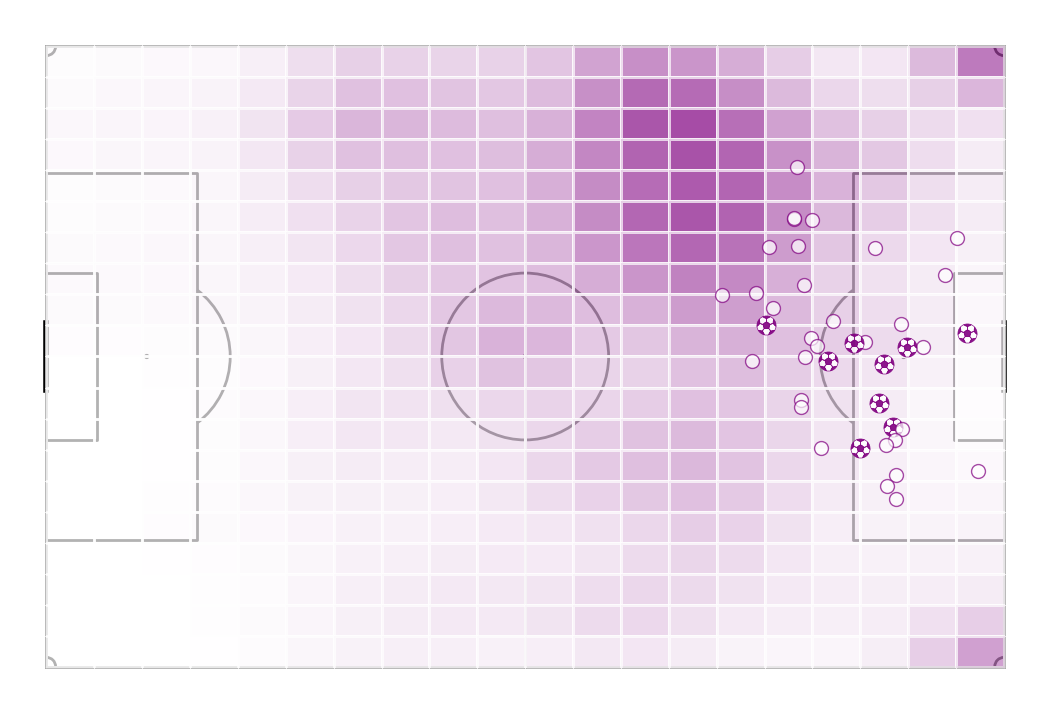

In [198]:
fig, ax = plt.subplots(figsize=(16, 9))
background = 'white'
fig.set_facecolor(background)
ax.set_facecolor(background)
xavi_touches = xavi[xavi['isTouch'] == True]
cmap = LinearSegmentedColormap.from_list('custom_cmap', [background, 'purple'])  # White to team color

pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=background, line_color='black', linewidth=2)
pitch.draw(ax=ax)
bin_statistic = pitch.bin_statistic(xavi_touches.x, xavi_touches.y, statistic='count', bins=(20, 20))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
pcm = pitch.heatmap(bin_statistic, ax=ax, cmap=cmap, edgecolors=background,alpha=0.7,zorder=1)

#pitch.lines(xavi_crosses.x, xavi_crosses.y, xavi_crosses.endX, xavi_crosses.endY, color='white', lw=2, alpha=0.6, comet=False, zorder=2, ax=ax)
#pitch.lines(xavi_assists.x, xavi_assists.y, xavi_assists.endX, xavi_assists.endY, color='white', lw=4, alpha=0.9,comet=False, zorder=5, ax=ax)

#pitch.scatter(xavi_crosses.endX, xavi_crosses.endY, s=20, color=background,edgecolor='white', alpha=0.6, zorder=5,ax=ax)
#pitch.scatter(xavi_assists.endX, xavi_assists.endY, s=50, color=background,edgecolor='white', alpha=0.9, zorder=5,ax=ax)

for _,row in xavi_shots.iterrows():
    if row['type'] == 'Goal':
        pitch.scatter(row.x, row.y, s=200,marker='football', c=background,edgecolors='purple', alpha=0.9, zorder=5,ax=ax)
    else:
        pitch.scatter(row.x, row.y, s=100,marker='o', c=background,edgecolors='purple', alpha=0.7, zorder=5,ax=ax)

plt.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/Images/Plots/XaviSimons.png',dpi=500,bbox_inches = 'tight',facecolor=background)

### Doku Vs Savinho

In [284]:
def dribbles_and_carry(ax,pname,team_color):
    pitch = VerticalPitch(pitch_type='uefa', corner_arcs=True, pitch_color=background, line_color='white', linewidth=1)
    pitch.draw(ax=ax)
    #ax.set_ylim(-0.5, 105.5)
    #ax.set_xlim(-0.5, 68.5)
    #plt.gca().invert_xaxis()

    df['prog_pass'] = np.where((df['type'] == 'Pass'),
                           np.sqrt((105 - df['x'])**2 + (34 - df['y'])**2) - np.sqrt((105 - df['endX'])**2 + (34 - df['endY'])**2), 0)
    # Calculating carrying distance, to find out progressive carry, this will just show the distance reduced by a carry, then will be able to filter carries which has reduced distance value more than 10yds as a progressive carry
    df['prog_carry'] = np.where((df['type'] == 'Carry'),
                                np.sqrt((105 - df['x'])**2 + (34 - df['y'])**2) - np.sqrt((105 - df['endX'])**2 + (34 - df['endY'])**2), 0)
    df['pass_or_carry_angle'] = np.degrees(np.arctan2(df['endY'] - df['y'], df['endX'] - df['x']))

    df_carry = df[(df['type']=='Carry') & (df['playerName']==pname)]
    led_shot1 = df[(df['type']=='Carry') & (df['playerName']==pname) & (df['qualifiers'].shift(-1).str.contains('KeyPass'))]
    led_shot2 = df[(df['type']=='Carry') & (df['playerName']==pname) & (df['type'].shift(-1).str.contains('Shot'))]
    led_shot = pd.concat([led_shot1, led_shot2])
    led_goal1 = df[(df['type']=='Carry') & (df['playerName']==pname) & (df['qualifiers'].shift(-1).str.contains('IntentionalAssist'))]
    led_goal2 = df[(df['type']=='Carry') & (df['playerName']==pname) & (df['type'].shift(-1)=='Goal')]
    led_goal3 = df[(df['type']=='Carry') & (df['playerName']==pname) & (df['type'].shift(-3)=='Goal')]
    led_goal12 = pd.concat([led_goal1, led_goal2])
    led_goal = pd.concat([led_goal12, led_goal3])
    pro_carry = df_carry[(df_carry['prog_carry']>=9.11) & (df_carry['x']>=35)]
    fth_carry = df_carry[(df_carry['x']<70) & (df_carry['endX']>=70)]
    box_entry = df_carry[(df_carry['endX']>=88.5) & (df_carry['endY']>=13.6) & (df_carry['endY']<=54.4) &
                 ~((df_carry['x']>=88.5) & (df_carry['y']>=13.6) & (df_carry['y']<=54.6))]
    disp = df[(df['type']=='Carry') & (df['playerName']==pname) & (df['type'].shift(-1)=='Dispossessed')]
    df_to = df[(df['type']=='TakeOn') & (df['playerName']==pname)]
    t_ons = df_to[df_to['outcomeType']=='Successful']
    t_onu = df_to[df_to['outcomeType']=='Unsuccessful']
    df_xT_inc = df_carry[df_carry['xT']>0]
    df_xT_dec = df_carry[df_carry['xT']<0]
    xT_by_Carry = df_carry['xT'].sum().round(2)
    df_carry = df_carry.copy()
    df_carry.loc[:, 'Length'] = np.sqrt((df_carry['x'] - df_carry['endX'])**2 + (df_carry['y'] - df_carry['endY'])**2)
    median_length = round(df_carry['Length'].median(),2)
    total_length = round(df_carry['Length'].sum(),2)
    if len(df_to)!=0:
        success_rate = round((len(t_ons)/len(df_to))*100, 2)
    else:
        success_rate = 0

        ax.add_patch(arrow)
    for index, row in pro_carry.iterrows():
        arrow = patches.FancyArrowPatch((row['y'], row['x']), (row['endY'], row['endX']), color='white', alpha=0.5, arrowstyle='->', linestyle='--', linewidth=2, 
                                   mutation_scale=20, zorder=3)
        ax.add_patch(arrow)
    for index, row in led_shot.iterrows():
        arrow = patches.FancyArrowPatch((row['y'], row['x']), (row['endY'], row['endX']), color='white', alpha=0.5, arrowstyle='->', linestyle='--', linewidth=2, 
                                   mutation_scale=20, zorder=4)
        ax.add_patch(arrow)
    for index, row in led_goal.iterrows():
        arrow = patches.FancyArrowPatch((row['y'], row['x']), (row['endY'], row['endX']), color='#c2ff83', alpha=0.9, arrowstyle='->', linestyle='--', linewidth=2, 
                                   mutation_scale=20, zorder=6)
        ax.add_patch(arrow)

    ax.scatter(t_ons.y, t_ons.x, s=100, color=team_color, edgecolor='white', lw=1,alpha=0.6, zorder=5)
    #ax.scatter(t_onu.y, t_onu.x, s=250, color='None', edgecolor='grey', hatch='/////', lw=1,alpha=0.5, zorder=5)

    #ax_text(68,118,f"{pname}\nCarries And Dribbles", color='white', fontsize=20,fontproperties=font_prop,ax=ax)
    df_xT = df[(df['xT'] > 0) & (df['type'].isin(['Pass','Carry'])) & (df['playerName']==pname)]
    cmap = LinearSegmentedColormap.from_list('custom_cmap', [background, team_color])  # White to team color

    bin_statistic = pitch.bin_statistic(df_xT.x, df_xT.y, statistic='count', bins=(20, 20))
    bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
    pcm = pitch.heatmap(bin_statistic, ax=ax, cmap=cmap, edgecolors=background,alpha=0.4,zorder=1)

    ax_text(70, -6, f'''
    Total Carries: {len(df_carry)}\n
    <Progressive Carries: {len(pro_carry)}>\n
    <Carries Led to Shot: {len(led_shot)}>\n
    <Carries Led to Goal: {len(led_goal)}>\n
    <Successful TakeOns: {len(t_ons)}/{len(df_to)}>
''', highlight_textprops=[{'color':'white'}, {'color':'white'}, {'color':'#c2ff83'}, {'color':team_color}],color='white', fontsize=18, ha='left', 
            va='top',fontproperties=font_prop, ax=ax)
    return

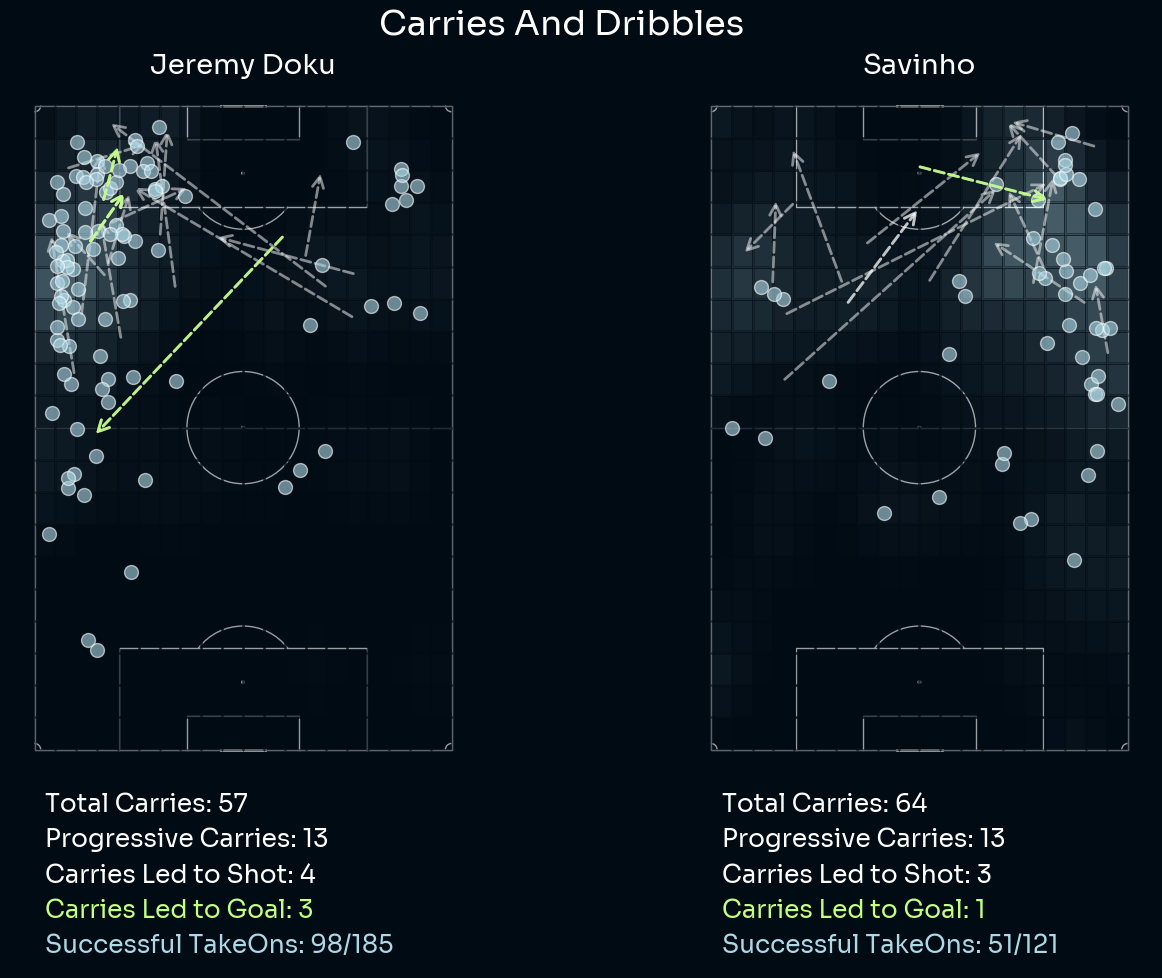

In [315]:
fig, axes = plt.subplots(1, 2, figsize=(16, 9), facecolor=background)

fig.suptitle(f'Carries And Dribbles', fontsize=25,fontproperties=font_prop, color='white', y=0.96)

axes[0].set_title(f'Jeremy Doku', color='white',fontproperties=font_prop,fontsize=20)
dribbles_and_carry(axes[0],'Jeremy Doku','lightblue')

axes[1].set_title(f'Savinho', color='white',fontproperties=font_prop,fontsize=20)
dribbles_and_carry(axes[1],'Savinho','lightblue')
fig.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/MatchReports/City/DokuVSav1.png',dpi=500,bbox_inches = 'tight',facecolor=background)

In [317]:
def chances_created_shots(ax,pname,team_color):
    pitch = VerticalPitch(pitch_type='uefa',half=True, corner_arcs=True, pitch_color=background, line_color='white', linewidth=1)
    pitch.draw(ax=ax)

    df_chances = df[(df['passKey'] == True) & (df['playerName'] == pname)]
    df_assists = df[(df['assist'] == True) & (df['playerName'] == pname)]
    df_xT = df[(df['xT'] > 0) & (df['type'].isin(['Pass','Carry'])) & (df['playerName']==pname)]

    df_shots = df[df['type'].isin(['Goal', 'SavedShot', 'MissedShots', 'ShotOnPost']) & (df['outcomeType'] == 'Successful')  & (df['playerName'] == pname)]

    pitch.lines(df_assists.x, df_assists.y, df_assists.endX, df_assists.endY, color='white', lw=4, alpha=0.8,comet=True, zorder=6, ax=ax)
    ax.scatter(df_assists.endY, df_assists.endX,marker='*', s=250, color=background,edgecolor='lightgreen', alpha=0.8, zorder=6)

    pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors", [background, team_color], N=20)

    path_eff = [path_effects.Stroke(linewidth=3, foreground=background), path_effects.Normal()]
    #pearl_earring_cmap = cm
    bin_statistic = pitch.bin_statistic(df_chances.x, df_chances.y, bins=(6,5), statistic='count', normalize=False)
    pitch.heatmap(bin_statistic, ax=ax, cmap=pearl_earring_cmap,zorder=1,alpha=0.4, edgecolors='#f8f8f8')

    labels = pitch.label_heatmap(bin_statistic, color='white', fontsize=15,alpha=0.6, ax=ax, ha='left', va='center', str_format='{:.0f}', path_effects=path_eff,zorder=5)

    for _,row in df_shots.iterrows():
        if row['type'] == 'Goal':
            pitch.scatter(row.x, row.y, s=300,marker='football', c=background,edgecolors=team_color, alpha=0.9, zorder=5,ax=ax)
        else:
            pitch.scatter(row.x, row.y, s=100,marker='o', c=background,edgecolors=team_color, alpha=0.7, zorder=5,ax=ax)

    ax_text(70, 47, f'''
    <Chances Created: {len(df_chances)}>\n
    <Assists: {len(df_assists)}>\n
    <Shots: {len(df_shots)}>\n
    <xT: {round(df_xT['xT'].sum(),2)}>
''', highlight_textprops=[{'color':'white'}, {'color':'white'}, {'color':'white'},{'color':'white'}],color='white', fontsize=20, ha='left', 
            va='top',fontproperties=font_prop, ax=ax)

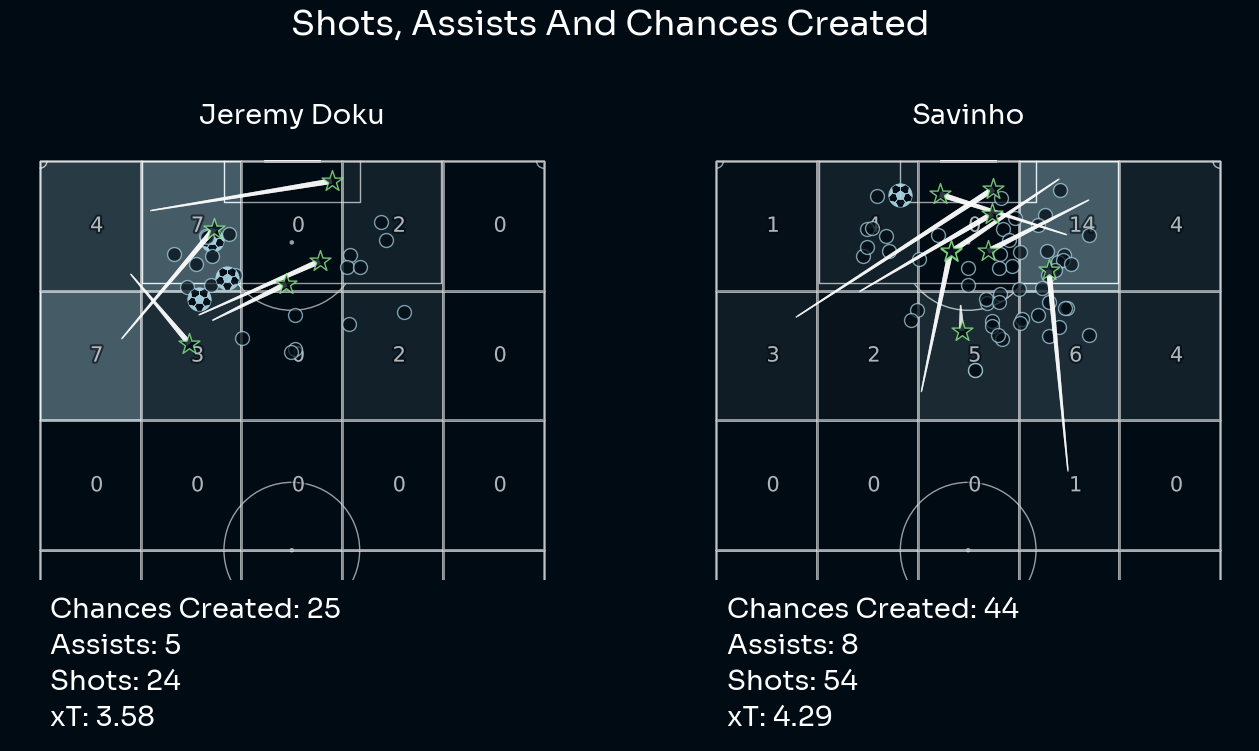

In [318]:
fig, axes = plt.subplots(1, 2, figsize=(16, 9), facecolor=background)

fig.suptitle(f'Shots, Assists And Chances Created', fontsize=25,fontproperties=font_prop, color='white', y=0.88)

axes[0].set_title(f'Jeremy Doku', color='white',fontproperties=font_prop,fontsize=20)
chances_created_shots(axes[0],'Jeremy Doku','lightblue')

axes[1].set_title(f'Savinho', color='white',fontproperties=font_prop,fontsize=20)
chances_created_shots(axes[1],'Savinho','lightblue')
fig.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/MatchReports/City/DokuVSav2.png',dpi=500,bbox_inches = 'tight',facecolor=background)

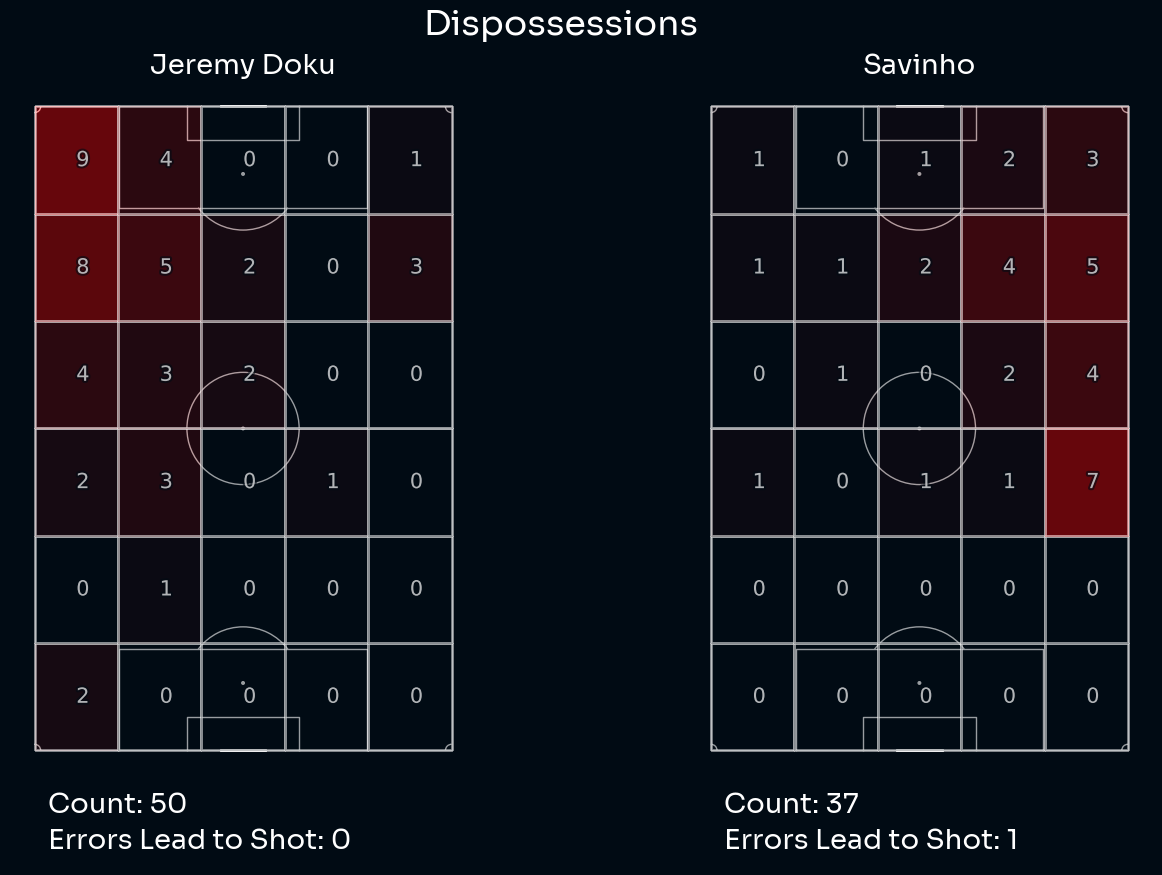

In [319]:
def dispossesed(ax,pname,team_color):
    pitch = VerticalPitch(pitch_type='uefa',half=False, corner_arcs=True, pitch_color=background, line_color='white', linewidth=1)
    pitch.draw(ax=ax)
    df_dispossessed = df[(df['dispossessed'] == True) & (df['playerName'] == pname)]
    df_errors = df[(df['errorLeadsToShot'] == True) & (df['playerName'] == pname)]

    pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors", [background, 'red'], N=20)

    path_eff = [path_effects.Stroke(linewidth=3, foreground=background), path_effects.Normal()]
    #pearl_earring_cmap = cm
    bin_statistic = pitch.bin_statistic(df_dispossessed.x, df_dispossessed.y, bins=(6,5), statistic='count', normalize=False)
    pitch.heatmap(bin_statistic, ax=ax, cmap=pearl_earring_cmap,zorder=1,alpha=0.4, edgecolors='#f8f8f8')

    labels = pitch.label_heatmap(bin_statistic, color='white', fontsize=15,alpha=0.6, ax=ax, ha='left', va='center', str_format='{:.0f}', path_effects=path_eff,zorder=5)

    ax_text(70, -6, f'''
    <Count: {len(df_dispossessed)}>\n
    <Errors Lead to Shot: {len(df_errors)}>
''', highlight_textprops=[{'color':'white'},{'color':'white'}],color='white', fontsize=20, ha='left', 
            va='top',fontproperties=font_prop, ax=ax)

fig, axes = plt.subplots(1, 2, figsize=(16, 9), facecolor=background)

fig.suptitle(f'Dispossessions', fontsize=25,fontproperties=font_prop, color='white', y=0.96)

axes[0].set_title(f'Jeremy Doku', color='white',fontproperties=font_prop,fontsize=20)
dispossesed(axes[0],'Jeremy Doku','lightblue')

axes[1].set_title(f'Savinho', color='white',fontproperties=font_prop,fontsize=20)
dispossesed(axes[1],'Savinho','lightblue')
fig.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/MatchReports/City/DokuVSav3.png',dpi=500,bbox_inches = 'tight',facecolor=background)

In [273]:
df[df['dispossessed'] == True].groupby('playerName').size()

playerName
Jeremy Doku    50
Savinho        37
dtype: int64

In [276]:
df[df['bigChanceMissed'] == True].groupby('playerName').size()

playerName
Savinho    6
dtype: int64

In [272]:
print(list(df.columns))

['eventId', 'minute', 'second', 'teamId', 'x', 'y', 'expandedMinute', 'period', 'type', 'outcomeType', 'qualifiers', 'satisfiedEventsTypes', 'isTouch', 'playerId', 'endX', 'endY', 'blockedX', 'blockedY', 'goalMouthZ', 'goalMouthY', 'isShot', 'relatedEventId', 'relatedPlayerId', 'isGoal', 'cardType', 'isOwnGoal', 'cumulative_mins', 'playerName', 'level_0', 'index', 'Unnamed: 0', 'h_a', 'matchId', 'startDate', 'startTime', 'score', 'ftScore', 'htScore', 'etScore', 'venueName', 'maxMinute', 'shotBodyType', 'situation', 'shotSixYardBox', 'shotPenaltyArea', 'shotOboxTotal', 'shotOpenPlay', 'shotCounter', 'shotSetPiece', 'shotDirectCorner', 'shotOffTarget', 'shotOnPost', 'shotOnTarget', 'shotsTotal', 'shotBlocked', 'shotRightFoot', 'shotLeftFoot', 'shotHead', 'shotObp', 'goalSixYardBox', 'goalPenaltyArea', 'goalObox', 'goalOpenPlay', 'goalCounter', 'goalSetPiece', 'penaltyScored', 'goalOwn', 'goalNormal', 'goalRightFoot', 'goalLeftFoot', 'goalHead', 'goalObp', 'shortPassInaccurate', 'shortPa

### Bruno G

In [12]:
merged_df = df.merge(player_df, left_on='playerName', right_on='display_name', how='left')

In [14]:
midfielders = merged_df[merged_df['position'].isin(['Central Midfield', 'Attacking Midfield','Defensive Midfield','Midfielder'])]

In [15]:
midfielders = merged_df[merged_df['position'].isin(['Defensive Midfield'])]

In [16]:
pname = 'Bruno Guimaraes'
metric = 'DefensiveActions'
get_rank_by_metric(midfielders, pname,metric,None)

,playerName,DefensiveActions,rank
5,Bruno Guimaraes,374,5.0


In [18]:
pname = 'Bruno Guimaraes'
metric = 'Key Passes'
get_rank_by_metric(midfielders, pname,metric,None)

,playerName,Key Passes,rank
4,Bruno Guimaraes,40,2.0


In [19]:
get_leaderboard_with_player(midfielders, pname,metric,2)

,playerName,Key Passes,rank,is_target_player
24,Ryan Christie,42,1.0,False
4,Bruno Guimaraes,40,2.0,True


### Defensive Heatmap Vs Key Passes

In [20]:
def find_defensive_actions(events_df):
    # Defensive Aerials
    aerials = events_df[events_df['type']=='Aerial']
    defensive_aerials = aerials[aerials['qualifiers'].apply(
    lambda x: isinstance(x, list) and any(isinstance(q, dict) and q.get('type', {}).get('value') == 285 for q in x))]

    # Define and filter defensive events
    defensive_actions = ['BallRecovery', 'BlockedPass', 'Clearance', 'Foul', 'Interception', 'Tackle',
                         'Claim', 'KeeperPickup', 'KeeperSweeper', 'Smother', 'Punch', 'Save','ShieldBallOpp']
    defensive_action_df = events_df[(events_df['type'].isin(defensive_actions)) & (events_df['outcomeType'] == 'Successful')]

    defensive_action_df = pd.concat([defensive_action_df,
                                     defensive_aerials], axis=0).sort_values(['matchId', 'cumulative_mins'])

    # Note challenges are never successful and represent when the opposition completes a take on
    return defensive_action_df

In [21]:
brunoG_def_df = find_defensive_actions(df[df['playerName'] == pname])

In [22]:
brunoG_key_passes = df[(df['playerName'] == pname) & (df['type'] == 'Pass') & (df['qualifiers'].str.contains('KeyPass', na=False)) & (df['outcomeType']=='Successful')]

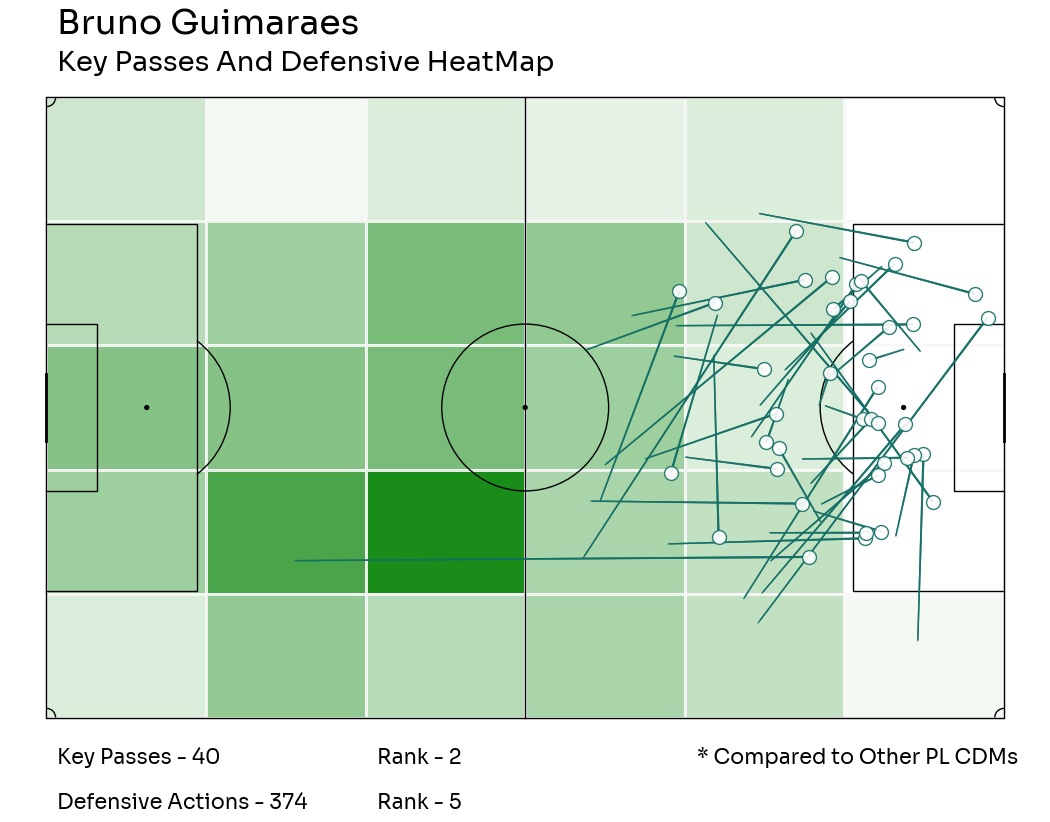

In [26]:
background = 'white'
fig,ax=plt.subplots(figsize=(16,9),facecolor=background)
pitch = Pitch(pitch_type='uefa',corner_arcs=True, pitch_color=background, line_color='black', linewidth=1,
                         positional=False, shade_middle=False, positional_color='black')
pitch.draw(ax=ax)

#kde = pitch.kdeplot(brunoG_def_df.x, brunoG_def_df.y, ax=ax, fill=True, levels=50, thresh=0, cmap='Greens', cut=5, alpha=0.9, antialiased=False, zorder=0)

pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors", ['white', 'green'], N=20)

path_eff = [path_effects.Stroke(linewidth=3, foreground=background), path_effects.Normal()]
#pearl_earring_cmap = cm
bin_statistic = pitch.bin_statistic(brunoG_def_df.x, brunoG_def_df.y, bins=(6,5), statistic='count', normalize=False)
pitch.heatmap(bin_statistic, ax=ax, cmap=pearl_earring_cmap,zorder=0,alpha=0.9, edgecolors='#f8f8f8')

pitch.lines(brunoG_key_passes.x, brunoG_key_passes.y, brunoG_key_passes.endX, brunoG_key_passes.endY, color='#146f65',  lw=1.5, alpha=0.9,comet=True, zorder=5, ax=ax)
pitch.scatter(brunoG_key_passes.endX, brunoG_key_passes.endY, s=100, color='white',edgecolor='#146f65', alpha=0.9, zorder=5,ax=ax)

fig.text(0.22,0.91,f'{pname}', fontproperties=font_prop,fontsize=25, color='black')
fig.text(0.22,0.87,f'Key Passes And Defensive HeatMap', fontsize=20,fontproperties=font_prop, color='black')

fig.text(0.22 , 0.1, f'Key Passes - {brunoG_key_passes.shape[0]}',fontproperties=font_prop,fontsize=15, color='black')
fig.text(0.42 , 0.1, f'Rank - 2',fontproperties=font_prop,fontsize=15, color='black')

fig.text(0.22 , 0.05, f'Defensive Actions - {brunoG_def_df.shape[0]}',fontproperties=font_prop,fontsize=15, color='black')
fig.text(0.42 , 0.05, f'Rank - 5',fontproperties=font_prop,fontsize=15, color='black')

fig.text(0.62 , 0.1, f'* Compared to Other PL CDMs',fontproperties=font_prop,fontsize=15, color='black')

plt.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/Images/Plots/BrunoG.png',dpi=500,bbox_inches = 'tight',facecolor=background)

### Key Passes and Dribbles

In [87]:
df[(df['assist'] == True) & (df['playerName'] == 'Eberechi Eze')].shape

(8, 272)

In [69]:
saka_chances = df[(df['passKey'] == True) & (df['playerName'] == 'Bukayo Saka')]
eze_chances = df[(df['passKey'] == True) & (df['playerName'] == 'Eberechi Eze')]

saka_assists = df[(df['assist'] == True) & (df['playerName'] == 'Bukayo Saka')]
eze_assists = df[(df['assist'] == True) & (df['playerName'] == 'Eberechi Eze')]

In [129]:
pname = 'Virgil van Dijk'
metric = 'BlockedPass'
get_rank_by_metric(df, pname,metric,None)

,playerName,BlockedPass,rank
414,Virgil van Dijk,10,32.0


In [115]:
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as path_effects
# setting the custom colormap

def player_passMap(df_assists,df_chances,ax, pname,team_color):
    pitch = VerticalPitch(pitch_type='uefa',half=True, corner_arcs=True, pitch_color=background, line_color='white', linewidth=1,
                         positional=False, shade_middle=False, positional_color=team_color, shade_color='grey',shade_alpha=0.3,positional_alpha=0.7)
    pitch.draw(ax=ax)

    #dfpass = df[(df['type']=='Pass') & (df['playerName']==pname)]
    #acc_pass = dfpass[dfpass['outcomeType']=='Successful']
    #iac_pass = dfpass[dfpass['outcomeType']=='Unsuccessful']

    #if len(dfpass) != 0:
    #    accurate_pass_perc = round((len(acc_pass)/len(dfpass))*100, 2)
    #else:
    #    accurate_pass_perc = 0
    #pro_pass = acc_pass[(acc_pass['prog_pass']>=9.11) & (acc_pass['x']>=35) &
    #                    (~acc_pass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    #through_pass = dfpass[(dfpass['qualifiers'].str.contains('Throughball'))]
    #through_pass_acc = through_pass[through_pass['outcomeType']=='Successful']
    #long_pass = dfpass[(dfpass['qualifiers'].str.contains('Longball'))]
    #long_pass_acc = long_pass[long_pass['outcomeType']=='Successful']
    #cross = dfpass[(dfpass['qualifiers'].str.contains('Cross'))]
    #cross_acc = cross[cross['outcomeType']=='Successful']
    #key_pass = acc_pass[acc_pass['qualifiers'].str.contains('KeyPass')]
    #big_chnc = dfpass[dfpass['qualifiers'].str.contains('BigChanceCreated')]
    #df_no_carry = df[df['type']!='Carry'].reset_index(drop=True)
    #pre_asst = df_no_carry[(df_no_carry['qualifiers'].shift(-1).str.contains('IntentionalGoalAssist')) & (df_no_carry['type']=='Pass') &
    #                       (df_no_carry['outcomeType']=='Successful') &  (df_no_carry['name']==pname)]
    #shot_buildup = df_no_carry[(df_no_carry['qualifiers'].shift(-1).str.contains('KeyPass')) & (df_no_carry['type']=='Pass') &
    #                       (df_no_carry['outcomeType']=='Successful') &  (df_no_carry['name']==pname)]
    #assist = acc_pass[acc_pass['qualifiers'].str.contains('IntentionalGoalAssist')]
    #fnl_thd = acc_pass[(acc_pass['endX']>=70) & (~acc_pass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    #pen_box = acc_pass[(acc_pass['endX']>=88.5) & (acc_pass['endY']>=13.6) & (acc_pass['endY']<=54.4) &
    #                   (~acc_pass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    
    #corners = dfpass[dfpass['qualifiers'].str.contains('CornerTaken')]
    #corners_acc = corners[corners['outcomeType']=='Successful']
    #freekick = dfpass[dfpass['qualifiers'].str.contains('Freekick')]
    #freekick_acc = freekick[freekick['outcomeType']=='Successful']
    #throws = dfpass[dfpass['qualifiers'].str.contains('ThrowIn')]
    #throws_acc = throws[throws['outcomeType']=='Successful']

    #df_xT_inc = acc_pass[acc_pass['xT']>0]
    #df_xT_dec = acc_pass[acc_pass['xT']<0]
    #xT_by_Pass = acc_pass['xT'].sum().round(2)

    #pitch.lines(iac_pass.y, iac_pass.x, iac_pass.endY, iac_pass.endX, color='grey', lw=2, alpha=0.15, comet=True, zorder=2, ax=ax)
    #pitch.lines(acc_pass.x, acc_pass.y, acc_pass.endX, acc_pass.endY, color='grey', lw=1, alpha=0.5, comet=False, zorder=2, ax=ax)
    #pitch.lines(key_pass.x, key_pass.y, key_pass.endX, key_pass.endY, color='lightgreen',  lw=1, alpha=0.6,comet=False, zorder=5, ax=ax)
    pitch.lines(df_assists.x, df_assists.y, df_assists.endX, df_assists.endY, color=team_color, lw=3.5, alpha=0.8,comet=True, zorder=6, ax=ax)
    #pitch.lines(pen_box.x, pen_box.y, pen_box.endX, pen_box.endY, color='yellow', lw=2, alpha=0.8,comet=False, zorder=4, ax=ax)
    #pitch.lines(fnl_thd.x, fnl_thd.y, fnl_thd.endX, fnl_thd.endY, color='yellow', lw=2, alpha=0.5,comet=False, zorder=3, ax=ax)
    
    #ax.scatter(acc_pass.endY, acc_pass.endX, s=50, color=background,edgecolor='white', alpha=0.5, zorder=2)
    #ax.scatter(key_pass.endY, key_pass.endX, s=100, color=background,edgecolor='lightgreen', alpha=0.7, zorder=5)
    ax.scatter(df_assists.endY, df_assists.endX, s=200, color=background,edgecolor=team_color, alpha=0.8, zorder=6)
    ax.scatter(df_assists.y.iloc[0], df_assists.x.iloc[0], s=200, color=background,edgecolor=team_color, alpha=0.8, zorder=6)
    #if df_assists.endX == None:
    #    ax.scatter(df_assists.y, df_assists.x, s=200, color=background,edgecolor=team_color, alpha=0.8, zorder=6)
    #ax.scatter(fnl_thd.endY, fnl_thd.endX, s=100, color=background,edgecolor='yellow', alpha=0.5, zorder=4)
    #ax.scatter(pen_box.endY, pen_box.endX, s=100, color=background,edgecolor='#eaea72', alpha=0.8, zorder=3)
    pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors", [background, 'lightgreen'], N=20)

    path_eff = [path_effects.Stroke(linewidth=3, foreground=background), path_effects.Normal()]
    #pearl_earring_cmap = cm
    bin_statistic = pitch.bin_statistic(df_chances.x, df_chances.y, bins=(6,5), statistic='count', normalize=False)
    pitch.heatmap(bin_statistic, ax=ax, cmap=pearl_earring_cmap,zorder=1,alpha=0.4, edgecolors='#f8f8f8')

    labels = pitch.label_heatmap(bin_statistic, color='white', fontsize=20, ax=ax, ha='left', va='center', str_format='{:.0f}', path_effects=path_eff,zorder=5)

    #df_to = df[(df['type']=='TakeOn') & (df['playerName']==pname)]
    #t_ons = df_to[df_to['outcomeType']=='Successful']
    #t_onu = df_to[df_to['outcomeType']=='Unsuccessful']

    #ax.scatter(t_ons.y, t_ons.x, s=150, color=team_color, edgecolor='white', lw=1, zorder=5)
    #ax.scatter(t_onu.y, t_onu.x, s=100, color='None', edgecolor='grey', hatch='/////', lw=1,alpha=0.5, zorder=5)

    #labels = pitch.label_heatmap(bin_statistic, color='white', fontsize=15,zorder=1,alpha=0.5, ax=ax, ha='center', va='center', str_format='{:.0f}', path_effects=path_eff)

    ax_text(70, 40, f'''
    <Assists: {len(df_assists)} (Rank-5)>\n
    <Chances Created: {len(df_chances)} (Rank-12)> \n
    ''',
    color='white',fontproperties=font_prop,
    highlight_textprops=[{'color':team_color},{'color':'lightgreen'}],zorder=10, fontsize=15, ha='left', va='center', ax=ax)
    return

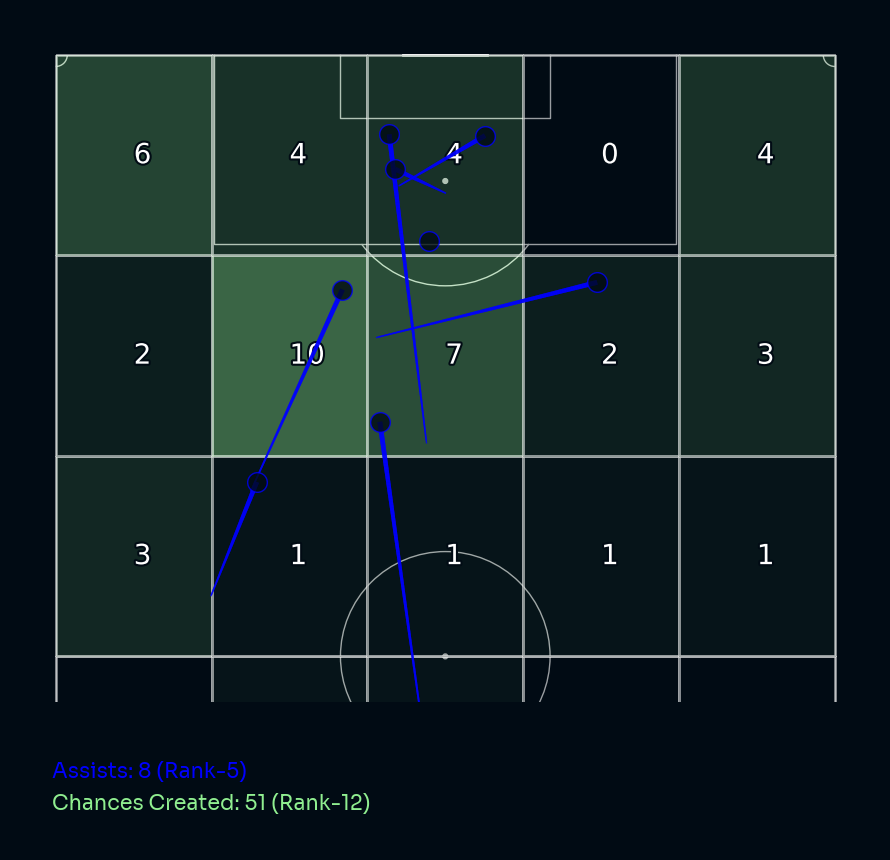

In [117]:
fig,ax=plt.subplots(figsize=(16,9),facecolor=background)
#pname = 'Rayan Cherki'
player_passMap(eze_assists,eze_chances,ax, pname,'blue')
'''
logo = mpimg.imread('C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/Score Logos-20241022T100701Z-001/Score Logos/ScoreSquareWhite.png')

ax_image = add_image(
    logo, fig, left=0.7, bottom=0.85, width=0.08, height=0.08,aspect='equal'
)

teamlogo = mpimg.imread('C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/Images/TeamLogos/Lyon.png')

ax_image = add_image(
    teamlogo, fig, left=0.25, bottom=0.85, width=0.08, height=0.08,aspect='equal'
)

fig.text(0.32,0.9,f'{pname}', fontsize=22,fontproperties=font_prop, color='white')
fig.text(0.32,0.87,f'Key Passes And Dribbles', fontsize=15,fontproperties=font_prop, color='white')
'''
plt.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/Images/Plots/Eze.png',dpi=500,bbox_inches = 'tight',facecolor=background)

### Key Passes Per90 Vs Dribbles Per90

In [176]:
player_minutes = df.groupby(['playerName', 'teamName', 'matchId'])['maxMinute'].max().reset_index()

# Step 2: Sum total minutes played across all matches
total_minutes_played = player_minutes.groupby(['playerName', 'teamName'])['maxMinute'].sum().reset_index()
total_minutes_played.rename(columns={'maxMinute': 'TotalMinutesPlayed'}, inplace=True)

eligible_players = total_minutes_played[(total_minutes_played['TotalMinutesPlayed'] >= 2000) & (total_minutes_played['playerName'] != 'nan')]

eligible_players_names = eligible_players['playerName'].unique()
key_passes_df = df[(df['type'] == 'Pass') & (df['outcomeType'] == 'Successful') & (df['playerName'].isin(eligible_players_names)) & (df['qualifiers'].str.contains('KeyPass'))]
#prog_passes_df = df[(df['type'] == 'Pass') & (df['outcomeType'] == 'Successful') & (df['playerName'].isin(eligible_players_names)) & (df['xT'] > 0)]
dribbles_df = df[(df['type']=='TakeOn') & (df['outcomeType']=='Successful') & (df['playerName'].isin(eligible_players_names))]

key_pass_per_match = key_passes_df.groupby(['playerName', 'teamName', 'matchId']).size().reset_index(name='key_passes')
key_pass_per90 = key_pass_per_match.groupby(['playerName', 'teamName'])['key_passes'].mean().reset_index()
key_pass_per90.rename(columns={'key_passes': 'KeyPassesPer90'}, inplace=True)

dribbles_per_match = dribbles_df.groupby(['playerName', 'teamName', 'matchId']).size().reset_index(name='dribbles')
dribbles_per90 = dribbles_per_match.groupby(['playerName', 'teamName'])['dribbles'].mean().reset_index()
dribbles_per90.rename(columns={'dribbles': 'DribblesPer90'}, inplace=True)

#prog_pass_per_match = prog_passes_df.groupby(['playerName', 'teamName', 'matchId']).size().reset_index(name='prog_passes')
#prog_pass_per90 = prog_pass_per_match.groupby(['playerName', 'teamName'])['prog_passes'].mean().reset_index()
#prog_pass_per90.rename(columns={'prog_passes': 'ProgPassesPer90'}, inplace=True)

In [177]:
passing_metrics_df = pd.merge(key_pass_per90, dribbles_per90[['playerName','DribblesPer90']], on=['playerName'], how='left')

In [178]:
passing_metrics_df = pd.merge(passing_metrics_df, eligible_players , on = ['playerName','teamName'],how='left')

In [179]:
# Ensure unique records before merging
key_pass_per90 = key_pass_per90.drop_duplicates(subset=['playerName', 'teamName'])
dribbles_per90 = dribbles_per90.drop_duplicates(subset=['playerName', 'teamName'])
eligible_players = eligible_players.drop_duplicates(subset=['playerName', 'teamName'])

# Merging
passing_metrics_df = pd.merge(key_pass_per90, 
                         dribbles_per90[['playerName', 'teamName', 'DribblesPer90']], 
                         on=['playerName', 'teamName'], 
                         how='left')

passing_metrics_df = pd.merge(passing_metrics_df, eligible_players, 
                         on=['playerName', 'teamName'], 
                         how='left')

# Drop duplicates after merging
passing_metrics_df = passing_metrics_df.drop_duplicates(subset=['playerName'], keep='first')

# Final check
print(passing_metrics_df.duplicated(subset=['playerName']).sum())  # Should be 0


0


In [180]:
print(passing_metrics_df['KeyPassesPer90'].min() , passing_metrics_df['KeyPassesPer90'].max() , passing_metrics_df['DribblesPer90'].min() , passing_metrics_df['DribblesPer90'].max())

1.0 3.391304347826087 1.0 4.619047619047619


In [117]:
passing_metrics_df = passing_metrics_df[(passing_metrics_df['KeyPassesPer90'] > 2) & (passing_metrics_df['ProgPassesPer90'] > 15)]

In [181]:
passing_metrics_df[passing_metrics_df['playerName'] == 'Rayan Cherki']

,playerName,teamName,KeyPassesPer90,DribblesPer90,TotalMinutesPlayed
808,Rayan Cherki,Lyon,2.944444,2.375,2107.0


In [184]:
print(passing_metrics_df.isnull().sum())  # Check missing values


playerName            0
teamName              0
KeyPassesPer90        0
DribblesPer90         0
TotalMinutesPlayed    0
dtype: int64


In [183]:
passing_metrics_df = passing_metrics_df.dropna(subset=['KeyPassesPer90', 'DribblesPer90', 'TotalMinutesPlayed'])


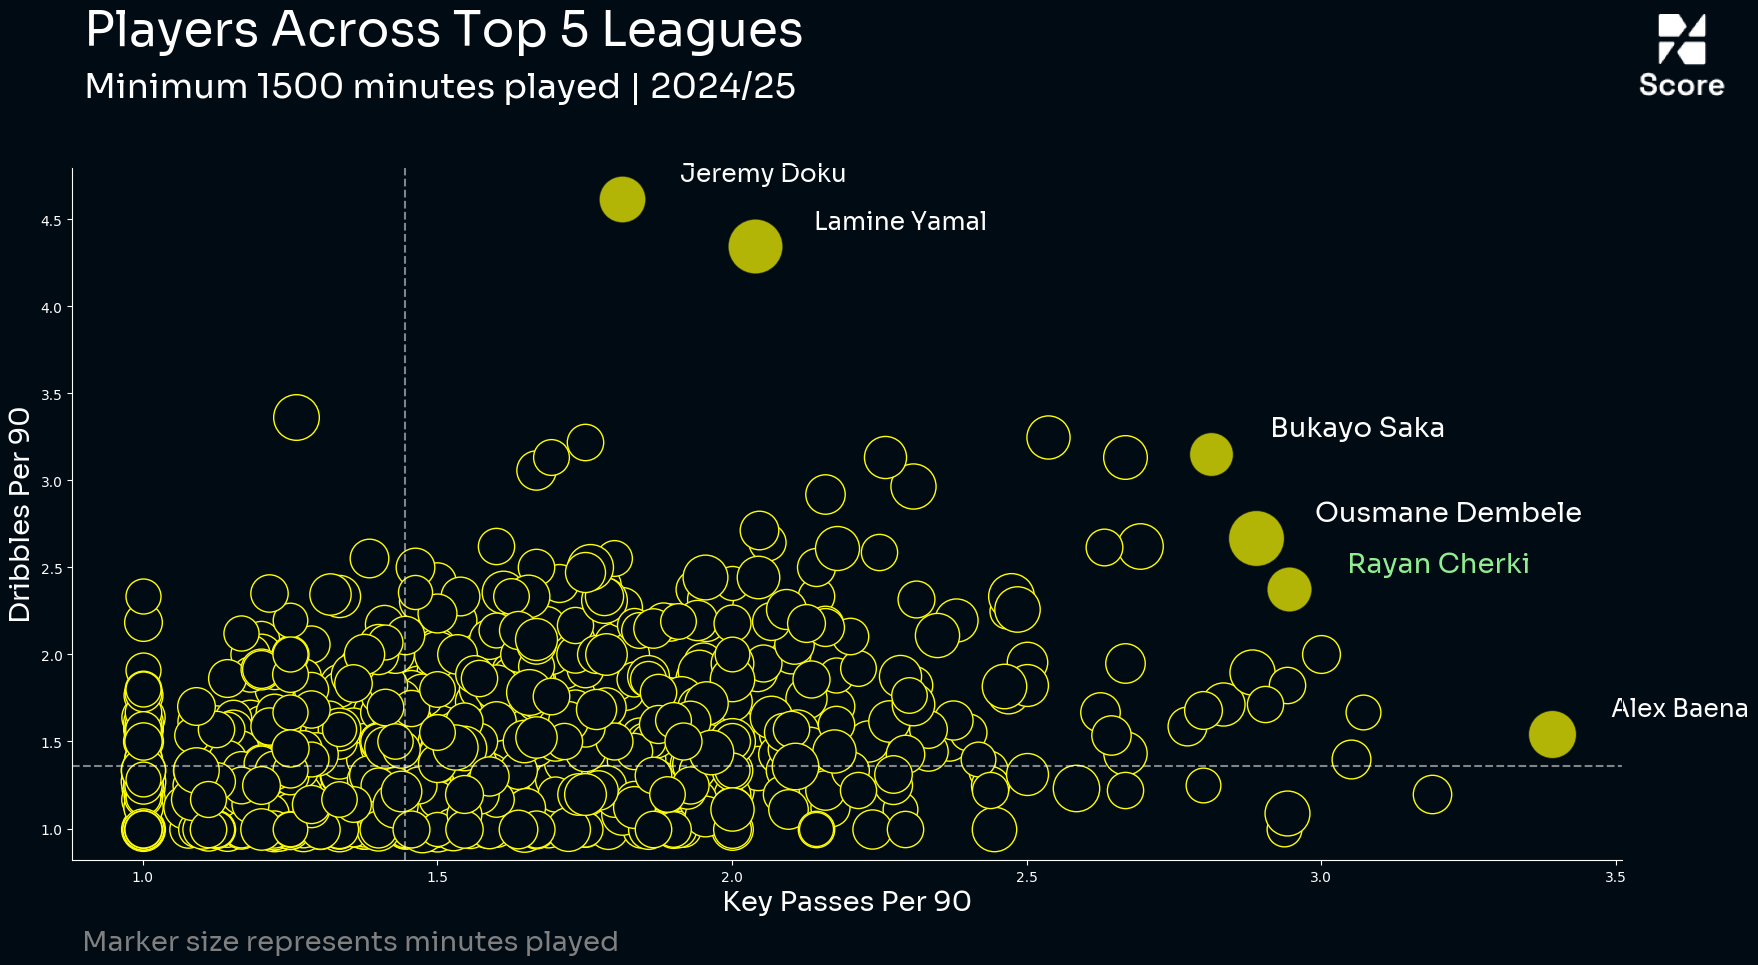

In [354]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

fig, ax = plt.subplots(figsize=(20,9))
fig.set_facecolor(background)
ax.set_facecolor(background)
ax.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.7)

for index,row in passing_metrics_df.iterrows():
    
    if ( (row['KeyPassesPer90'] >= 2.75) & (row['DribblesPer90'] > 2.3)):
        ax.scatter(row['KeyPassesPer90'], row['DribblesPer90'],color='yellow',s=row['TotalMinutesPlayed'] * 0.5,edgecolor=background,zorder=1,alpha=0.7)
        if row['playerName'] == 'Rayan Cherki':
            text_color = 'lightgreen'
        else:
            text_color = 'white'
        ax.annotate(row['playerName'],xy = (row['KeyPassesPer90']+0.1,row['DribblesPer90']+0.1),fontproperties=font_prop,color=text_color,fontsize=20,zorder=2)
    elif ( ((row['KeyPassesPer90'] >= 3.25)) or ((row['DribblesPer90'] > 4.0)) ):
        ax.scatter(row['KeyPassesPer90'], row['DribblesPer90'],color='yellow',s=row['TotalMinutesPlayed'] * 0.5,edgecolor=background,zorder=1,alpha=0.7)
        ax.annotate(row['playerName'],xy = (row['KeyPassesPer90']+0.1,row['DribblesPer90']+0.1),fontproperties=font_prop,color='white',fontsize=18,zorder=2)
    else:
        ax.scatter(row['KeyPassesPer90'], row['DribblesPer90'],color=background,s=row['TotalMinutesPlayed'] * 0.3,edgecolor='yellow')
    
  


median_key_passes = passing_metrics_df['KeyPassesPer90'].median()
median_prog_passes = passing_metrics_df['DribblesPer90'].median()
ax.axvline(median_key_passes, color='white', linestyle='--', lw=1.5,alpha=0.5,zorder=1)
ax.axhline(median_prog_passes, color='white', linestyle='--', lw=1.5,alpha=0.5,zorder=1)

logo = mpimg.imread('C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/Score Logos-20241022T100701Z-001/Score Logos/ScoreSquareWhite.png')

ax_image = add_image(
    logo, fig, left=0.88, bottom=0.95, width=0.1, height=0.1,aspect='equal'
)

ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.spines['top'].set_color(background)
ax.spines['right'].set_color(background)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

ax.set_xlabel("Key Passes Per 90",fontproperties=font_prop,color='white',fontsize=20)
ax.set_ylabel("Dribbles Per 90",fontproperties=font_prop,color='white',fontsize=20)
ax.grid(False)
#ax.set_title("Top GoalKeepers - LaLiga 2024/25",fontproperties=font_prop,color='white',fontsize=32,y=1.07)
#ax.suptitle("Players With 100+ Passes and Carries",fontsize=18,color='white')
ax.text(0.9, 5.5, "Players Across Top 5 Leagues", fontproperties=font_prop,ha='left', fontsize=35,color='white')
ax.text(0.9, 5.2, "Minimum 1500 minutes played | 2024/25", fontproperties=font_prop,ha='left', fontsize=25,color='white')

fig.text(0.13,0.01, "Marker size represents minutes played", fontproperties=font_prop,ha='left', fontsize=20,color='grey')


#ax.scatter(2, 99,edgecolor='yellow',s=500,color=background)
plt.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/Images/Plots/Cherki1.png',dpi=500,bbox_inches = 'tight',facecolor=background)


### Zone 14 Analysis

In [457]:
passes_df = df[(df['type'] == 'Pass') & (df['outcomeType'] == 'Successful')] 

zone14 = passes_df[(passes_df['endX'] >= 70) & (passes_df['endX'] <= 88.54) & (passes_df['endY'] >= 22.66) & (passes_df['endY'] <= 45.32)]

# Count passes per player
pass_counts = zone14.groupby('playerName').agg(
    Passes=('index', 'count'),  # Count total passes in Zone 14
    Total_xT=('xT', 'sum')  # Sum of xT for passes into Zone 14
).reset_index()

In [458]:
pass_counts['Total_xT'] = round(pass_counts['Total_xT'],2)

In [460]:
pass_counts.head()

,playerName,Passes,Total_xT
0,Aaron Cresswell,3,0.02
1,Aaron Ramsdale,10,0.13
2,Aaron Wan-Bissaka,25,0.08
3,Abdoulaye Doucoure,34,-0.07
4,Abdukodir Khusanov,8,0.03


In [461]:
# Rename column for clarity
pass_counts.rename(columns={'index': 'Passes'}, inplace=True)

# Get the top 12 players
top_9_players = pass_counts.nlargest(9, 'Passes')

In [462]:
top_9_players

,playerName,Passes,Total_xT
306,Mateo Kovacic,197,0.43
238,Josko Gvardiol,127,0.04
461,Youri Tielemans,103,0.48
331,Moises Caicedo,100,0.38
173,Ilkay Gundogan,92,-0.02
136,Enzo Fernandez,86,0.10
89,Cole Palmer,84,0.19
290,Manuel Akanji,84,0.08
64,Bruno Guimaraes,80,0.41


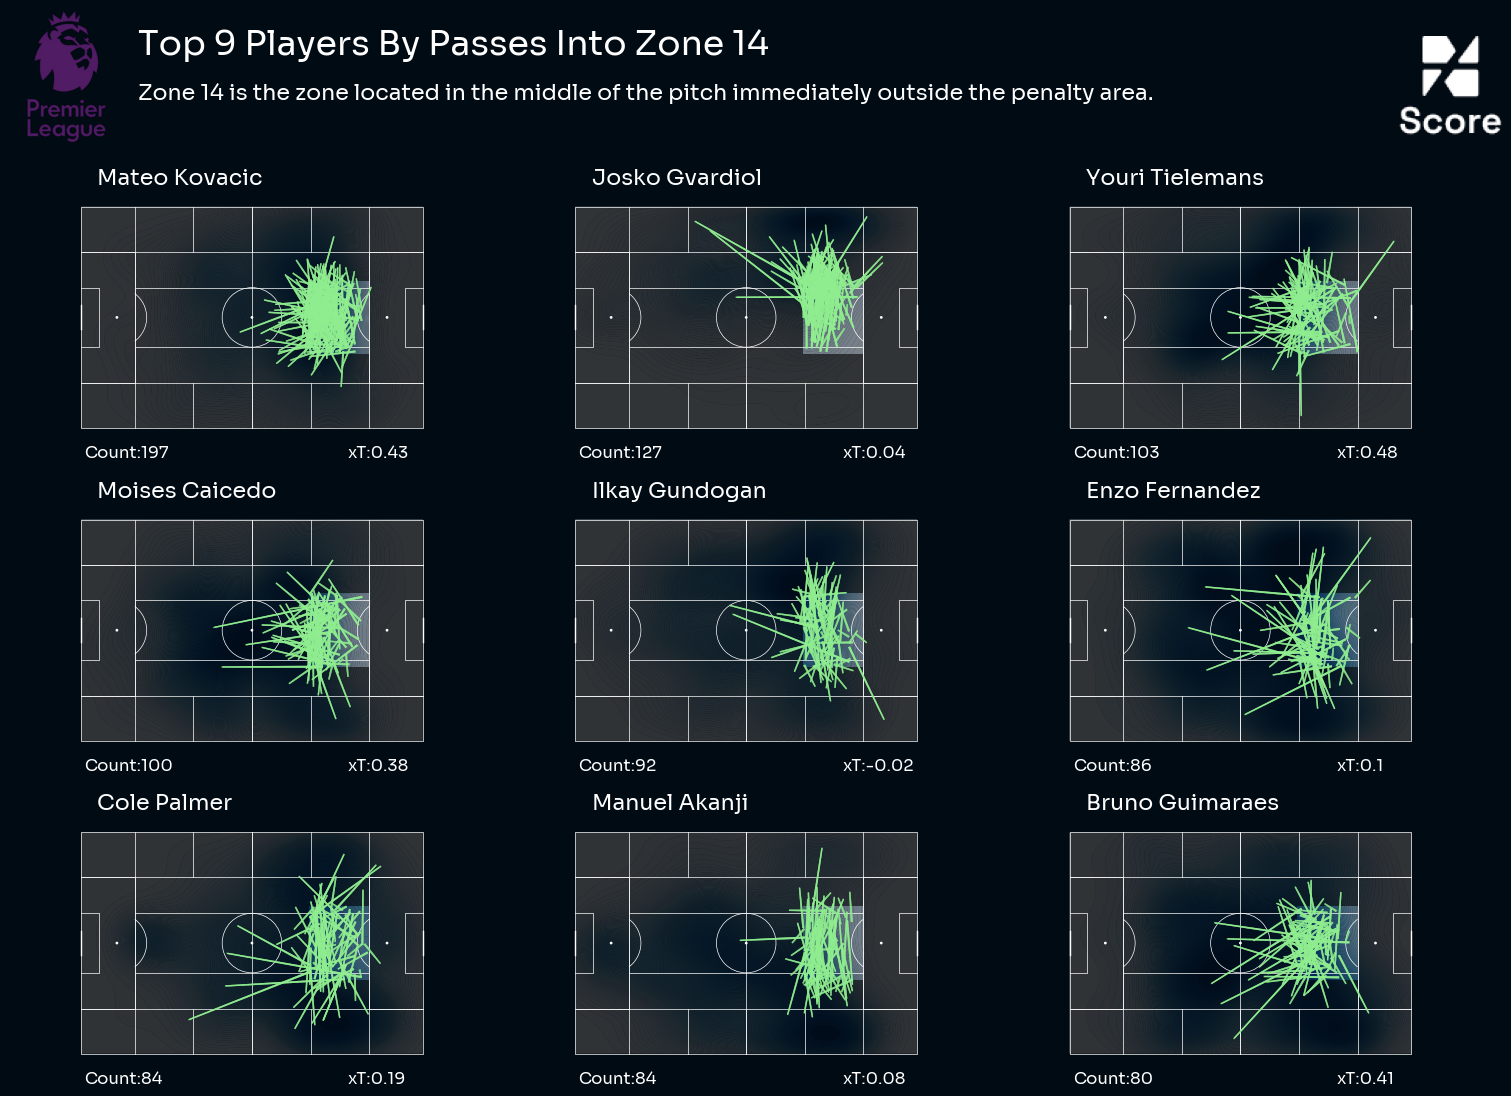

In [479]:
# Set-up pitch subplots
pitch = Pitch(pitch_color=background,half=False, pitch_type='uefa', line_color='white', linewidth=0.5,positional=True,positional_color='white',
                      #pad_left=-30,  # bring the left axis in 10 data units (reduce the size)
                      #pad_right=-10,  # bring the right axis in 10 data units (reduce the size)
                      #pad_top=10,  # extend the top axis 10 data units
                      #pad_bottom=20,
                      stripe=False)
fig, ax = pitch.grid(nrows=3, ncols=3,  # the figure height in inches
                      bottom=0.025,  # starts 2.5% in from the figure bottom
                      # increased the grid_height as no title/ endnote
                      # now it takes up 95% of the figheight
                      grid_height=0.97,
                      grid_width=0.88,  # the grid takes up 95% of the figwidth
                      # 6% of the grid_height is the space between pitches.
                      space=0.15,
                      # set the endnote/title height to zero so
                      # they are not plotted. note this automatically
                      # sets the endnote/title space to zero
                      # so the grid starts at the bottom/left location
                      endnote_height=0, title_height=0, axis=False)
plt.subplots_adjust(hspace=-2)
fig.set_size_inches(16, 9)
fig.set_facecolor(background)

ax = ax.reshape(-1)

# Plot successful prog passes as arrows, using for loop to iterate through each player and each pass
idx = 0

for _, row in top_9_players.iterrows():
    player_name = row['playerName']
    player_pass_actions = passes_df[passes_df['playerName'] == player_name]
    player_zone14_actions = zone14[zone14['playerName'] == player_name]
    
    ax[idx].text(5,75,f"{player_name}", fontweight="bold", color='w',fontproperties=font_prop, fontsize=16)
    ax[idx].text(1, -9, f"Count:{len(player_zone14_actions)}", fontproperties=font_prop,fontsize=12, color='w', zorder=1)
    ax[idx].text(82, -9, f"xT:{row['Total_xT']}", fontproperties=font_prop,fontsize=12, color='w', zorder=1)

    # KDE plot for defensive actions
    pitch.kdeplot(player_pass_actions['endX'], player_pass_actions['endY'], ax=ax[idx], fill=True, 
                  levels=80, thresh=0, cmap='Blues', cut=8, alpha=0.5, antialiased=True, zorder=0)  
    #pitch.kdeplot(player_pass_actions['endX'], player_pass_actions['endY'], ax=ax[idx], fill=True, 
    #              levels=100, thresh=0, cmap='Blues', cut=8, alpha=0.6, antialiased=True, zorder=0)  

    # Shade the left (defensive) third
    ax[idx].fill([0, 70, 70, 0],[0, 0, 68, 68], 'black', alpha=0.6, zorder=0)

    # Shade the right (attacking) third
    ax[idx].fill([88.54, 105, 105, 88.54], [0, 0, 68, 68],'black', alpha=0.6, zorder=0)

    ax[idx].fill([70, 88.54, 88.54, 70], [0, 0, 22.66, 22.66],'black', alpha=0.6, zorder=0)

    ax[idx].fill([70, 88.54, 88.54, 70], [45.32, 45.32, 68, 68],'black', alpha=0.6, zorder=0)

    # Scatter plot for defensive actions
    #pitch.scatter(player_pass_actions['endX'], player_pass_actions['endY'], color='k', alpha=0.2, s=12, zorder=1, ax=ax[idx])
    pitch.lines(player_zone14_actions.x, player_zone14_actions.y, player_zone14_actions.endX, player_zone14_actions.endY, color='lightgreen',  lw=1.5,
                alpha=0.9,comet=True, zorder=10, ax=ax[idx])
    #pitch.scatter(player_zone14_actions['endX'], player_zone14_actions['endY'], color='w', alpha=0.6, s=12, zorder=1, ax=ax[idx])

    #ax[idx].text(0, -8, "Passes Into Zone 14:",fontproperties=font_prop ,fontsize=10, fontweight='bold', color='w', zorder=1)
    

    idx += 1
    if idx >= 12:  # Prevents out-of-bounds error
        break


title_text = f"Top 9 Players By Passes Into Zone 14"
subtitle_text = f""
info_text = "Zone 14 is the zone located in the middle of the pitch immediately outside the penalty area."

# Title
fig.text(0.12, 1.15, title_text, fontweight="bold",fontproperties=font_prop, fontsize=25, color='w')
fig.text(0.12, 1.1, info_text, fontweight="regular",fontproperties=font_prop, fontsize=16, color='w')
#fig.text(0.12, 0, info_text, fontweight="regular",fontproperties=font_prop, fontsize=18, color='w')



# Add direction of play arrow
#ax = fig.add_axes([0.042, 0.05, 0.18, 0.01])
#ax.axis("off")
#plt.arrow(0.51, 0.15, 0.1, 0, color="white")
#fig.text(0.13, 0.03, "Direction of play", ha="center",fontproperties=font_prop, fontsize=12, color="white", fontweight="regular")

logo = mpimg.imread('C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/Score Logos-20241022T100701Z-001/Score Logos/ScoreSquareWhite.png')

ax_image = add_image(
    logo, fig, left=0.88, bottom=1.05, width=0.12, height=0.12,aspect='equal'
)

league_logo = mpimg.imread('C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/Images/TeamLogos/pl.png')

ax_image = add_image(
    league_logo, fig, left=0, bottom=1.05, width=0.15, height=0.15,aspect='equal'
)

plt.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/Images/Plots/PL_Zone14.png',dpi=500,bbox_inches = 'tight',facecolor=background)

### Passes Into Final Third

In [56]:
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as path_effects
# setting the custom colormap

def player_passMap_ft(ax, pname,team_color):
    pitch = VerticalPitch(pitch_type='uefa',half=True, corner_arcs=True, pitch_color=background, line_color='white', linewidth=1,
                         positional=False, shade_middle=False, positional_color=team_color, shade_color='grey',shade_alpha=0.3,positional_alpha=0.7)
    pitch.draw(ax=ax)

    dfpass = df[(df['type']=='Pass') & (df['playerName']==pname)]
    acc_pass = dfpass[dfpass['outcomeType']=='Successful']
    iac_pass = dfpass[dfpass['outcomeType']=='Unsuccessful']

    if len(dfpass) != 0:
        accurate_pass_perc = round((len(acc_pass)/len(dfpass))*100, 2)
    else:
        accurate_pass_perc = 0
    #pro_pass = acc_pass[(acc_pass['prog_pass']>=9.11) & (acc_pass['x']>=35) &
    #                    (~acc_pass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    #through_pass = dfpass[(dfpass['qualifiers'].str.contains('Throughball'))]
    #through_pass_acc = through_pass[through_pass['outcomeType']=='Successful']
    #long_pass = dfpass[(dfpass['qualifiers'].str.contains('Longball'))]
    #long_pass_acc = long_pass[long_pass['outcomeType']=='Successful']
    #cross = dfpass[(dfpass['qualifiers'].str.contains('Cross'))]
    #cross_acc = cross[cross['outcomeType']=='Successful']
    #key_pass = acc_pass[acc_pass['qualifiers'].str.contains('KeyPass')]
    #big_chnc = dfpass[dfpass['qualifiers'].str.contains('BigChanceCreated')]
    #df_no_carry = df[df['type']!='Carry'].reset_index(drop=True)
    #pre_asst = df_no_carry[(df_no_carry['qualifiers'].shift(-1).str.contains('IntentionalGoalAssist')) & (df_no_carry['type']=='Pass') &
    #                       (df_no_carry['outcomeType']=='Successful') &  (df_no_carry['name']==pname)]
    #shot_buildup = df_no_carry[(df_no_carry['qualifiers'].shift(-1).str.contains('KeyPass')) & (df_no_carry['type']=='Pass') &
    #                       (df_no_carry['outcomeType']=='Successful') &  (df_no_carry['name']==pname)]
    assist = acc_pass[acc_pass['qualifiers'].str.contains('IntentionalGoalAssist')]
    fnl_thd = acc_pass[(acc_pass['endX']>70.13) & (~acc_pass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    #pen_box = acc_pass[(acc_pass['endX']>=88.5) & (acc_pass['endY']>=13.6) & (acc_pass['endY']<=54.4) &
    #                   (~acc_pass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    
    #corners = dfpass[dfpass['qualifiers'].str.contains('CornerTaken')]
    #corners_acc = corners[corners['outcomeType']=='Successful']
    #freekick = dfpass[dfpass['qualifiers'].str.contains('Freekick')]
    #freekick_acc = freekick[freekick['outcomeType']=='Successful']
    #throws = dfpass[dfpass['qualifiers'].str.contains('ThrowIn')]
    #throws_acc = throws[throws['outcomeType']=='Successful']

    df_xT_inc = acc_pass[acc_pass['xT']>0]
    df_xT_dec = acc_pass[acc_pass['xT']<0]
    xT_by_Pass = acc_pass['xT'].sum().round(2)

    #pitch.lines(iac_pass.y, iac_pass.x, iac_pass.endY, iac_pass.endX, color='grey', lw=2, alpha=0.15, comet=True, zorder=2, ax=ax)
    #pitch.lines(acc_pass.x, acc_pass.y, acc_pass.endX, acc_pass.endY, color='grey', lw=1, alpha=0.5, comet=False, zorder=2, ax=ax)
    #pitch.lines(key_pass.x, key_pass.y, key_pass.endX, key_pass.endY, color='lightgreen',  lw=1, alpha=0.6,comet=False, zorder=5, ax=ax)
    pitch.lines(assist.x, assist.y, assist.endX, assist.endY, color=team_color, lw=3.5, alpha=1,comet=True, zorder=6, ax=ax)
    #pitch.lines(pen_box.x, pen_box.y, pen_box.endX, pen_box.endY, color='yellow', lw=2, alpha=0.8,comet=False, zorder=4, ax=ax)
    pitch.lines(fnl_thd.x, fnl_thd.y, fnl_thd.endX, fnl_thd.endY, color=team_color, lw=1, alpha=0.5,comet=False, zorder=3, ax=ax)
    
    #ax.scatter(acc_pass.endY, acc_pass.endX, s=50, color=background,edgecolor='white', alpha=0.5, zorder=2)
    #ax.scatter(key_pass.endY, key_pass.endX, s=100, color=background,edgecolor='lightgreen', alpha=0.7, zorder=5)
    ax.scatter(assist.endY, assist.endX, s=100, color=background,edgecolor=team_color, alpha=1, zorder=6)
    ax.scatter(fnl_thd.endY, fnl_thd.endX, s=100, color=background,edgecolor='white', alpha=0.5, zorder=4)
    #ax.scatter(pen_box.endY, pen_box.endX, s=100, color=background,edgecolor='#eaea72', alpha=0.8, zorder=3)
    pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors", [background, 'lightblue'], N=20)

    path_eff = [path_effects.Stroke(linewidth=3, foreground=background), path_effects.Normal()]
    #pearl_earring_cmap = cm
    bin_statistic = pitch.bin_statistic(fnl_thd.x, fnl_thd.y, bins=(6,5), statistic='count', normalize=False)
    pitch.heatmap(bin_statistic, ax=ax, cmap=pearl_earring_cmap,zorder=1,alpha=0.2, edgecolors='#f8f8f8')

    df_to = df[(df['type']=='TakeOn') & (df['playerName']==pname)]
    t_ons = df_to[df_to['outcomeType']=='Successful']
    t_onu = df_to[df_to['outcomeType']=='Unsuccessful']

    #ax.scatter(t_ons.y, t_ons.x, s=150, color=team_color, edgecolor='white', lw=1, zorder=5)
    #ax.scatter(t_onu.y, t_onu.x, s=100, color='None', edgecolor='grey', hatch='/////', lw=1,alpha=0.5, zorder=5)

    #labels = pitch.label_heatmap(bin_statistic, color='white', fontsize=15,zorder=1,alpha=0.5, ax=ax, ha='center', va='center', str_format='{:.0f}', path_effects=path_eff)

    ax_text(70, 40, f'''
    Accurate Passes: {len(acc_pass)}/{len(dfpass)} ({accurate_pass_perc}%) \n
    <Final Third Passes: {len(fnl_thd)}> \n
    xT : {xT_by_Pass}
    ''',
    color='white',fontproperties=font_prop,
    highlight_textprops=[{'color':team_color}],zorder=10, fontsize=18, ha='left', va='center', ax=ax)
    return

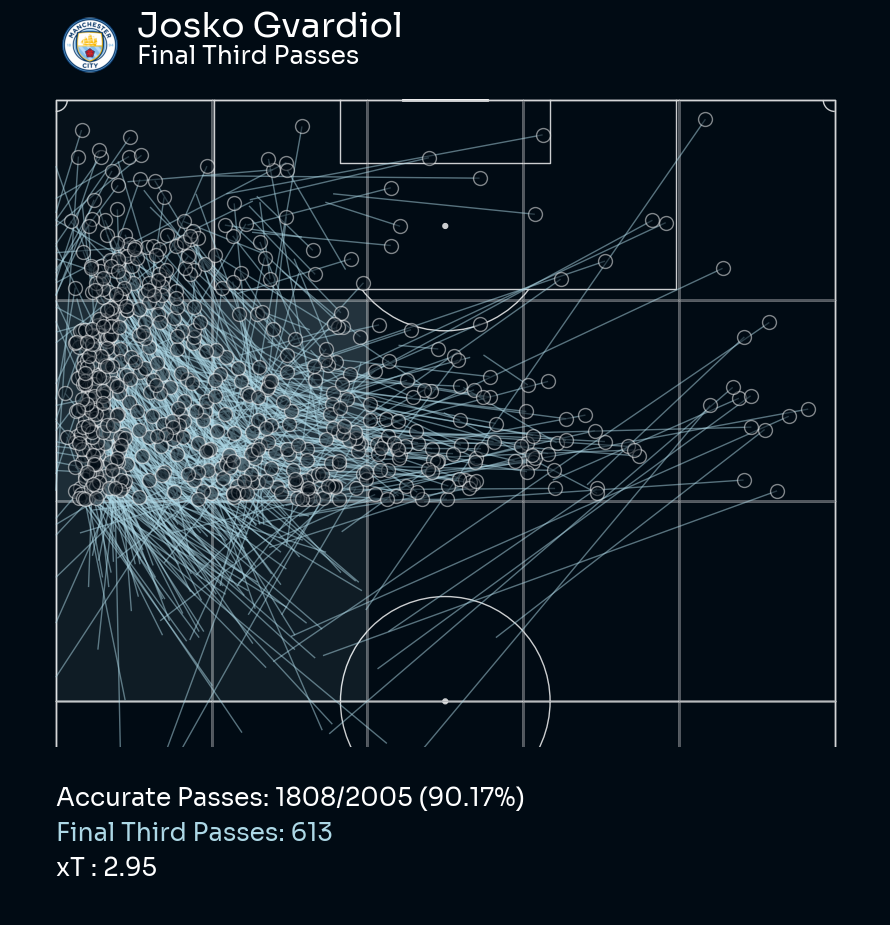

In [58]:
fig,ax=plt.subplots(figsize=(16,9),facecolor=background)
pname = 'Josko Gvardiol'
player_passMap_ft(ax, pname,'lightblue')


teamlogo = mpimg.imread('C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/Images/TeamLogos/Man City.png')

ax_image = add_image(
    teamlogo, fig, left=0.25, bottom=0.85, width=0.08, height=0.08,aspect='equal'
)

fig.text(0.32,0.9,f'{pname}', fontsize=25,fontproperties=font_prop, color='white')
fig.text(0.32,0.87,f'Final Third Passes', fontsize=18,fontproperties=font_prop, color='white')

plt.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/Images/Plots/Josko.png',dpi=500,bbox_inches = 'tight',facecolor=background)

### Possession Won In Final Third

In [67]:
df[df['teamName'] == 'Ajax']['playerName'].unique()

array(['Anton Gaaei', 'Josip Sutalo', 'Youri Baas', 'Mika Godts',
       'Steven Berghuis', 'Kristian Hlynsson', 'Sivert Mannsverk',
       'Branco van den Boomen', 'Dies Janse', 'Remko Pasveer',
       'Chuba Akpom', 'nan', 'Jordan Henderson', 'Carlos Forbs',
       'Kenneth Taylor', 'Bertrand Traore', 'Brian Brobbey',
       'Jorrel Hato', 'Kian Fitz-Jim', 'Davy Klaassen', 'Devyne Rensch',
       'Wout Weghorst', 'Daniele Rugani', 'Owen Wijndal',
       'Ahmetcan Kaplan', 'Christian Rasmussen', 'Matheus',
       'Jorthy Mokio', 'Oliver Edvardsen', 'Don-Angelo Konadu',
       'Steven Bergwijn', 'Jaydon Banel', 'Diant Ramaj',
       'Benjamin Tahirovic', 'Youri Regeer', 'Rayane Bounida',
       'Sean Steur', 'Lucas Rosa'], dtype=object)

In [68]:
pname = 'Bertrand Traore'
df_player = df[(df['playerName'] == pname)]

### Scatter Plot - ShotsP90 V BallRecover in FT

In [107]:
player_minutes = df.groupby(['playerName', 'teamName', 'matchId'])['maxMinute'].max().reset_index()

# Step 2: Sum total minutes played across all matches
total_minutes_played = player_minutes.groupby(['playerName', 'teamName'])['maxMinute'].sum().reset_index()
total_minutes_played.rename(columns={'maxMinute': 'TotalMinutesPlayed'}, inplace=True)

eligible_players = total_minutes_played[(total_minutes_played['TotalMinutesPlayed'] >= 2000) & (total_minutes_played['playerName'] != 'nan')]

eligible_players_names = eligible_players['playerName'].unique()
shots_df = df[(df['type'].isin(['Goal','SavedShot','MissedShots','ShotOnPost'])) & (df['outcomeType'] == 'Successful') & (df['playerName'].isin(eligible_players_names))]
br_ft_df = df[(df['type'] == 'BallRecovery') & (df['x'] > 70.13) & (df['outcomeType']=='Successful') & (df['playerName'].isin(eligible_players_names))]

shots_per_match = shots_df.groupby(['playerName', 'teamName', 'matchId']).size().reset_index(name='shots')
shots_per90 = shots_per_match.groupby(['playerName', 'teamName'])['shots'].mean().reset_index()
shots_per90.rename(columns={'shots': 'ShotsPer90'}, inplace=True)

ballrec_per_match = br_ft_df.groupby(['playerName', 'teamName', 'matchId']).size().reset_index(name='ballrec')
ballrec_per90 = ballrec_per_match.groupby(['playerName', 'teamName'])['ballrec'].mean().reset_index()
ballrec_per90.rename(columns={'ballrec': 'BallRecPer90'}, inplace=True)

In [108]:
metrics_df = pd.merge(shots_per90, ballrec_per90[['playerName','BallRecPer90']], on=['playerName'], how='left')

In [109]:
metrics_df = pd.merge(metrics_df, eligible_players , on = ['playerName','teamName'],how='left')

In [110]:
# Ensure unique records before merging
shots_per90 = shots_per90.drop_duplicates(subset=['playerName', 'teamName'])
ballrec_per90 = ballrec_per90.drop_duplicates(subset=['playerName', 'teamName'])
eligible_players = eligible_players.drop_duplicates(subset=['playerName', 'teamName'])

# Merging
passing_metrics_df = pd.merge(shots_per90, 
                         ballrec_per90[['playerName', 'teamName', 'BallRecPer90']], 
                         on=['playerName', 'teamName'], 
                         how='left')

metrics_df = pd.merge(metrics_df, eligible_players, 
                         on=['playerName', 'teamName'], 
                         how='left')

# Drop duplicates after merging
metrics_df = metrics_df.drop_duplicates(subset=['playerName'], keep='first')

# Final check
print(metrics_df.duplicated(subset=['playerName']).sum())  # Should be 0


0


In [111]:
print(metrics_df['BallRecPer90'].min() , metrics_df['BallRecPer90'].max() , metrics_df['ShotsPer90'].min() , metrics_df['ShotsPer90'].max())

1.0 3.0 1.0 3.4285714285714284


In [112]:
metrics_df[metrics_df['playerName'] == pname]

,playerName,teamName,ShotsPer90,BallRecPer90,TotalMinutesPlayed_x,TotalMinutesPlayed_y
12,Bertrand Traore,Ajax,2.555556,1.307692,2376.0,2376.0


In [113]:
metrics_df = metrics_df.dropna(subset=['BallRecPer90', 'ShotsPer90', 'TotalMinutesPlayed_x'])

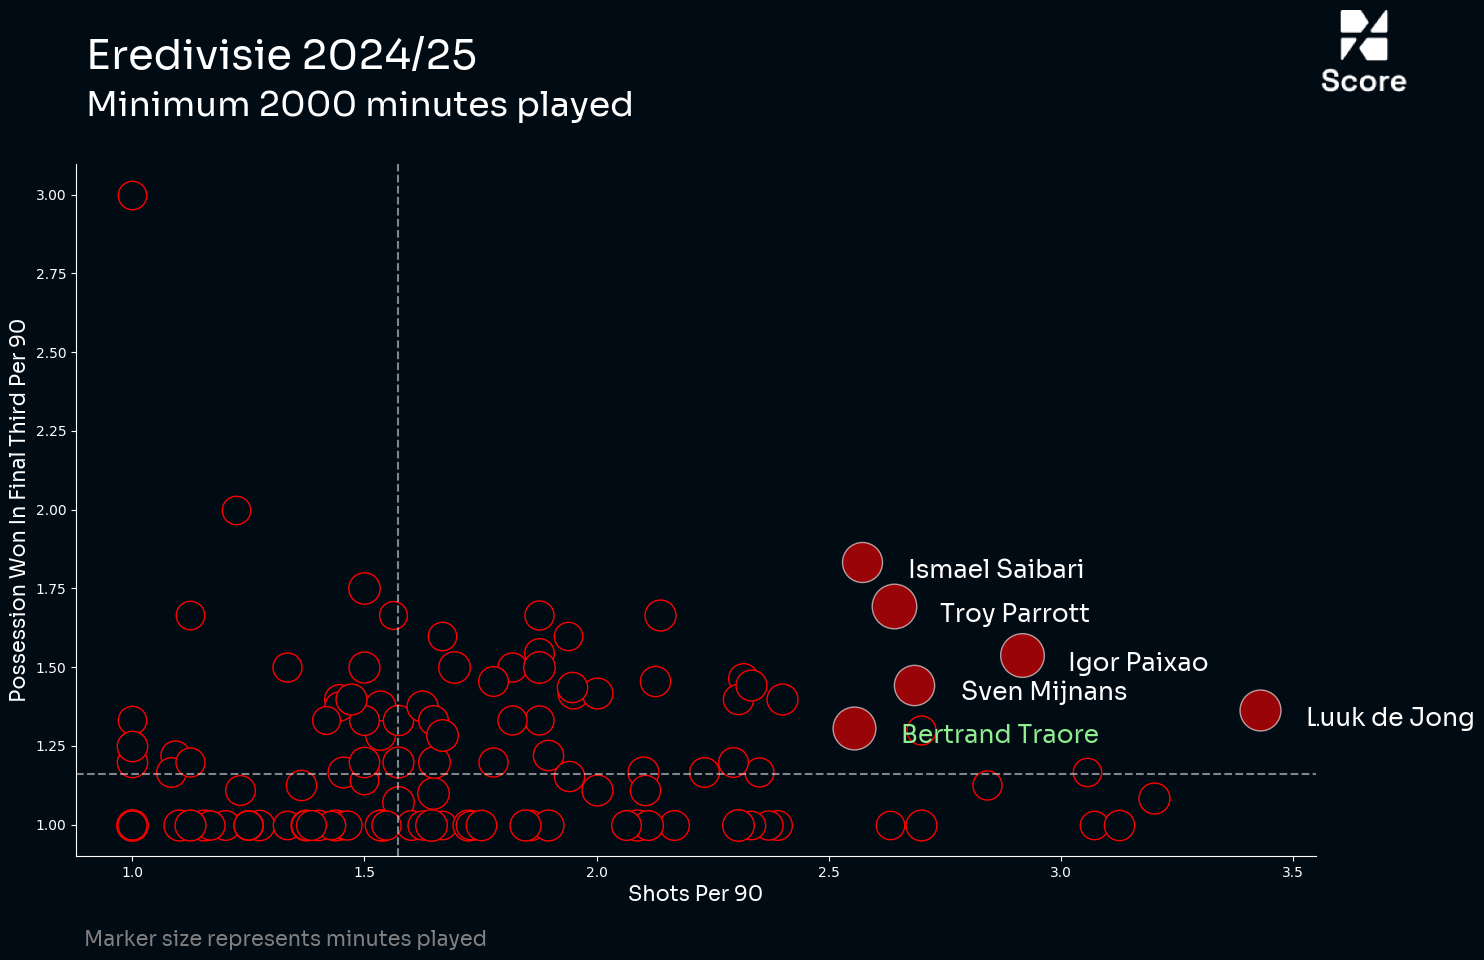

In [167]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

fig, ax = plt.subplots(figsize=(16,9))
fig.set_facecolor(background)
ax.set_facecolor(background)
ax.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.7)

for index,row in metrics_df.iterrows():
    
    if ( (row['ShotsPer90'] >= 2.5) & (row['BallRecPer90'] > 1.3)):
        ax.scatter(row['ShotsPer90'], row['BallRecPer90'],color='red',s=row['TotalMinutesPlayed_x'] * 0.4,edgecolor='white',zorder=1,alpha=0.6)
        if row['playerName'] == pname:
            text_color = 'lightgreen'
        else:
            text_color = 'white'
        ax.annotate(row['playerName'],xy = (row['ShotsPer90']+0.1,row['BallRecPer90']-0.05),fontproperties=font_prop,color=text_color,fontsize=18,zorder=2)
    else:
        ax.scatter(row['ShotsPer90'], row['BallRecPer90'],color=background,s=row['TotalMinutesPlayed_x'] * 0.2,edgecolor='red')
    
  


median_key_passes = passing_metrics_df['ShotsPer90'].median()
median_prog_passes = passing_metrics_df['BallRecPer90'].median()
ax.axvline(median_key_passes, color='white', linestyle='--', lw=1.5,alpha=0.5,zorder=1)
ax.axhline(median_prog_passes, color='white', linestyle='--', lw=1.5,alpha=0.5,zorder=1)

logo = mpimg.imread('C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/Score Logos-20241022T100701Z-001/Score Logos/ScoreSquareWhite.png')

ax_image = add_image(
    logo, fig, left=0.88, bottom=0.95, width=0.1, height=0.1,aspect='equal'
)

ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.spines['top'].set_color(background)
ax.spines['right'].set_color(background)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')


ax.set_xlabel("Shots Per 90",fontproperties=font_prop,color='white',fontsize=15)
ax.set_ylabel("Possession Won In Final Third Per 90",fontproperties=font_prop,color='white',fontsize=15)
ax.grid(False)
#ax.set_title("Top GoalKeepers - LaLiga 2024/25",fontproperties=font_prop,color='white',fontsize=32,y=1.07)
#ax.suptitle("Players With 100+ Passes and Carries",fontsize=18,color='white')
ax.text(0.9, 3.4, "Eredivisie 2024/25", fontproperties=font_prop,ha='left', fontsize=30,color='white')
ax.text(0.9, 3.25, "Minimum 2000 minutes played", fontproperties=font_prop,ha='left', fontsize=25,color='white')

fig.text(0.13,0.01, "Marker size represents minutes played", fontproperties=font_prop,ha='left', fontsize=15,color='grey')


#ax.scatter(2, 99,edgecolor='yellow',s=500,color=background)
plt.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/Images/Plots/BT1.png',dpi=500,bbox_inches = 'tight',facecolor=background)



### Touchmap

In [148]:
def touchMap(ax,df, pname,team1_facecolor):
    pitch = Pitch(pitch_type='uefa', half=False, corner_arcs=True, pitch_color=background, line_color='white', linewidth=0.5)
    pitch.draw(ax=ax)
    #ax.set_ylim(-0.5, 105.5)
    #ax.set_xlim(-0.5, 68.5)
    #plt.gca().invert_xaxis()

    df_player = df[df['playerName'] == pname]
    df_player = df_player[~df_player['type'].str.contains('SubstitutionOff|SubstitutionOn|Card|Carry')]
    new_data = pd.DataFrame({'y': [-5, -5, 110, 110], 'x': [-5, 73, 73, -5]})
    df_player = pd.concat([df_player, new_data], ignore_index=True)

    # Get touch coordinates
    touches = df_player[df_player['isTouch'] == 1]
    touches_final_third = touches[touches['x']>=70]
    touch_coords = touches[['x', 'y']].values

    player_touches = df.groupby('playerName')['isTouch'].count().reset_index()

    # Rename column for clarity
    player_touches.rename(columns={'isTouch': 'total_touches'}, inplace=True)
    
    # Rank players based on total touches (higher touches = better rank)
    player_touches['rank'] = player_touches['total_touches'].rank(method='dense', ascending=False)

    # Calculate mean and standard deviation
    if len(touch_coords) > 0:
        mean_x = np.mean(touch_coords[:, 0])
        mean_y = np.mean(touch_coords[:, 1])
        std_x = np.std(touch_coords[:, 0])
        std_y = np.std(touch_coords[:, 1])

        # Create boundaries for territory
        x_min = mean_x - std_x
        x_max = mean_x + std_x
        y_min = mean_y - std_y
        y_max = mean_y + std_y

        # Filter the points within one standard deviation
        valid_coords = touch_coords[
            (touch_coords[:, 0] >= x_min) & (touch_coords[:, 0] <= x_max) &
            (touch_coords[:, 1] >= y_min) & (touch_coords[:, 1] <= y_max)
        ]

        # Create a convex hull for the filtered points
        if len(valid_coords) > 2:  # Convex hull requires at least 3 points
            hull = ConvexHull(valid_coords)
            hull_points = valid_coords[hull.vertices]

            # Fill the territory with a grey color
            ax.fill(hull_points[:, 0], hull_points[:, 1], color='grey', alpha=0.3)

    # Scatter plot for touches
    ax.scatter(touches.x, touches.y, marker='o', ec=team1_facecolor, s=100, color=background)
    ax.scatter(mean_x, mean_y, marker='o', ec=team1_facecolor, s=1000, color='white', zorder=3)
    ax.text(mean_x-1, mean_y - 0.8, pname[:2], color='black', fontproperties=font_prop, fontsize=15)

    # Return touch statistics if needed
    return

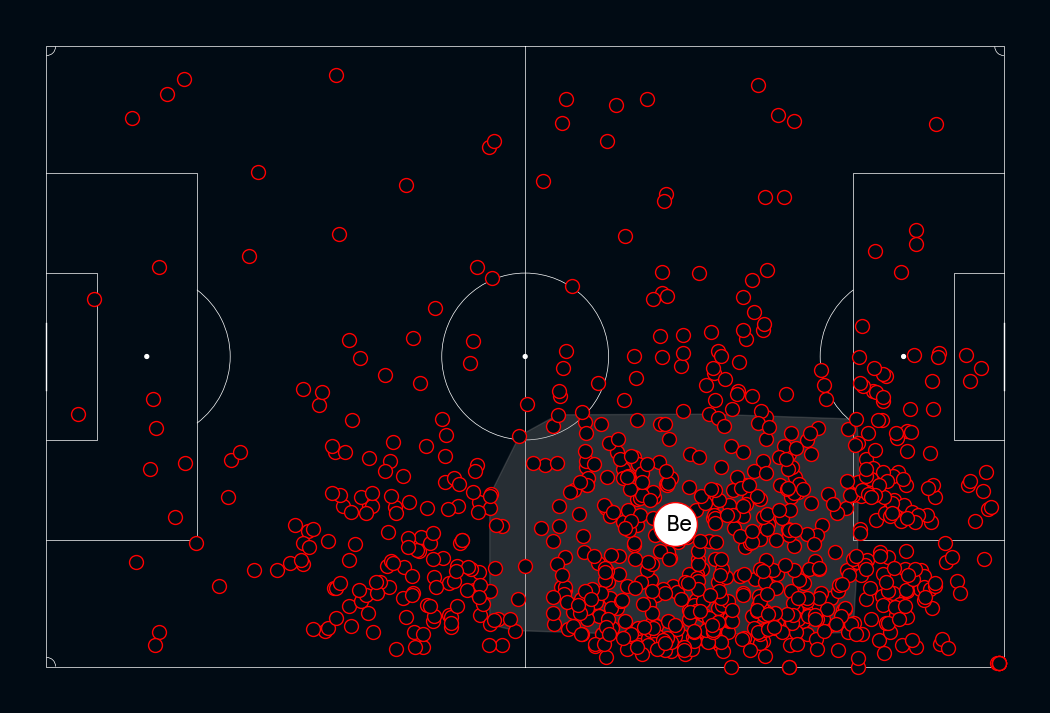

In [149]:
fig,ax=plt.subplots(figsize=(16,9),facecolor=background)
touchMap(ax,df, pname,'red')